### <font color=green>A. </font>深層学習／VAE (Variational Autoencoder) を実装する
https://qiita.com/jun40vn/items/374763f478ee094c5041

#### <font color=red>1. </font>Autoencoderの実装

In [1]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# データセット読み込み
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [4]:
# モデル構築
encoding_dim = 32
input_img = Input(shape=(784,))

x1 = Dense(256, activation='relu')(input_img)  
x2 = Dense(64, activation='relu')(x1)  

encoded = Dense(encoding_dim, activation='relu')(x2) 

x3 = Dense(64, activation='relu')(encoded)
x4 = Dense(256, activation='relu')(x3)  

decoded = Dense(784, activation='sigmoid')(x4) 

autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_7 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_10 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_11 (Dense)             (None, 784)              

In [8]:
# 学習
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 5s 22ms/step - loss: 0.6936 - val_loss: 0.6935
Epoch 2/50
235/235 [==============================] - 5s 21ms/step - loss: 0.6934 - val_loss: 0.6933
Epoch 3/50
235/235 [==============================] - 5s 21ms/step - loss: 0.6933 - val_loss: 0.6932
Epoch 4/50
235/235 [==============================] - 5s 21ms/step - loss: 0.6931 - val_loss: 0.6930
Epoch 5/50
235/235 [==============================] - 5s 21ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 6/50
235/235 [==============================] - 5s 21ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 7/50
235/235 [==============================] - 5s 22ms/step - loss: 0.6927 - val_loss: 0.6926
Epoch 8/50
235/235 [==============================] - 5s 22ms/step - loss: 0.6925 - val_loss: 0.6925
Epoch 9/50
235/235 [==============================] - 5s 21ms/step - loss: 0.6924 - val_loss: 0.6923
Epoch 10/50
235/235 [==============================] - 5s 21ms/step - loss: 0.6922 - val_lo

In [9]:
# 学習モデルでテスト画像を変換
decoded_imgs = autoencoder.predict(x_test)

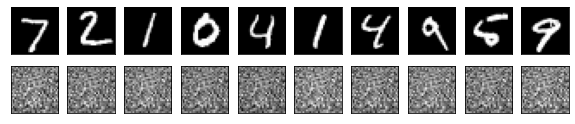

In [10]:
n = 10
plt.figure(figsize=(10, 2))

for i in range(n):
  # テスト画像を表示
  ax = plt.subplot(2, n, i+1)
  plt.imshow(x_test[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # 変換画像を表示
  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(decoded_imgs[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

#### <font color=red>2. </font>VAE全体の実装

In [13]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse 
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# データセット読み込み
(x_train, y_train), (x_test, y_test) = mnist.load_data()
image_size = x_train.shape[1] # = 784
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

input_shape = (original_dim, )
latent_dim = 2 ## 潜在空間の次元

In [15]:
# Reparametrization Trick 
def sampling(args):
  z_mean, z_logvar = args
  batch = K.shape(z_mean)[0]
  dim = K.int_shape(z_mean)[1]
  epsilon = K.random_normal(shape=(batch, dim), seed = 5) # ε
  return z_mean + K.exp(0.5 * z_logvar) * epsilon

In [16]:
# VAEモデル構築
inputs = Input(shape=input_shape)
x1 = Dense(256, activation='relu')(inputs)  
x2 = Dense(64, activation='relu')(x1) 

z_mean = Dense(latent_dim)(x2)
z_logvar = Dense(latent_dim)(x2)

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_logvar])

encoder = Model(inputs, [z_mean, z_logvar, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 256)          200960      input_3[0][0]                    
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 64)           16448       dense_12[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 2)            130         dense_13[0][0]                   
____________________________________________________________________________________________

In [17]:
latent_inputs = Input(shape=(latent_dim,))
x3 = Dense(64, activation='relu')(latent_inputs)  
x4 = Dense(256, activation='relu')(x3)  

outputs = Dense(original_dim, activation='sigmoid')(x4)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_17 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_18 (Dense)             (None, 784)               201488    
Total params: 218,320
Trainable params: 218,320
Non-trainable params: 0
_________________________________________________________________


In [18]:
z_output = encoder(inputs)[2]
outputs = decoder(z_output)

vae = Model(inputs, outputs, name='variational_autoencoder')

In [19]:
## 損失関数

# Kullback-Leibler Loss
kl_loss = 1 + z_logvar - K.square(z_mean) - K.exp(z_logvar)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

# Reconstruction Loss
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim

In [20]:
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.fit(x_train,
        epochs=50,
        batch_size=256,
        validation_data=(x_test, None))

Epoch 1/50
235/235 [==============================] - 5s 23ms/step - loss: 58.9791 - val_loss: 47.2649
Epoch 2/50
235/235 [==============================] - 5s 23ms/step - loss: 45.6552 - val_loss: 44.4028
Epoch 3/50
235/235 [==============================] - 5s 23ms/step - loss: 43.6514 - val_loss: 42.9320
Epoch 4/50
235/235 [==============================] - 5s 23ms/step - loss: 42.5482 - val_loss: 42.2597
Epoch 5/50
235/235 [==============================] - 5s 23ms/step - loss: 41.7684 - val_loss: 41.5341
Epoch 6/50
235/235 [==============================] - 5s 23ms/step - loss: 41.1961 - val_loss: 41.1351
Epoch 7/50
235/235 [==============================] - 5s 23ms/step - loss: 40.6595 - val_loss: 40.6322
Epoch 8/50
235/235 [==============================] - 5s 23ms/step - loss: 40.2001 - val_loss: 40.2090
Epoch 9/50
235/235 [==============================] - 5s 22ms/step - loss: 39.7734 - val_loss: 39.8573
Epoch 10/50
235/235 [==============================] - 5s 23ms/step - los

In [21]:
# テスト画像を変換
decoded_imgs = vae.predict(x_test)

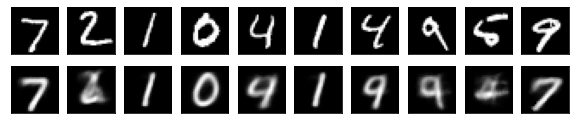

In [22]:
# テスト画像と変換画像の表示
n = 10
plt.figure(figsize=(10, 2))

for i in range(n):
  # テスト画像を表示
  ax = plt.subplot(2, n, i+1)
  plt.imshow(x_test[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # 変換された画像を表示
  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(decoded_imgs[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

#### <font color=red>3. </font>潜在空間zを平面で表してみる

In [23]:
import matplotlib.cm as cm

In [24]:
def plot_results(encoder,
                 decoder,
                 x_test,
                 y_test,
                 batch_size=128,
                 model_name="vae_mnist"):
  z_mean, _, _ = encoder.predict(x_test,
                                 batch_size=128)
  plt.figure(figsize=(12, 10))
  cmap=cm.tab10
  plt.scatter(z_mean[:, 0], z_mean[:, 1], c=cmap(y_test))
  m = cm.ScalarMappable(cmap=cmap)
  m.set_array(y_test)
  plt.colorbar(m)
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.show()

  # (-4, -4) から (4, 4) までを30x30分割してプロットする
  n = 30  # 50>30
  digit_size = 28
  figure = np.zeros((digit_size * n, digit_size * n))
  grid_x = np.linspace(-4, 4, n)
  grid_y = np.linspace(-4, 4, n)[::-1]

  for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
      z_sample = np.array([[xi, yi]])
      x_decoded = decoder.predict(z_sample)
      digit = x_decoded[0].reshape(digit_size, digit_size)
      figure[i * digit_size: (i + 1) * digit_size,
             j * digit_size: (j + 1) * digit_size] = digit

  plt.figure(figsize=(10, 10))

  start_range = digit_size // 2
  end_range = n * digit_size + start_range + 1
  pixel_range = np.arange(start_range, end_range, digit_size)

  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)

  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)

  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.axis('off')

  plt.imshow(figure, cmap='Greys_r')
  #plt.savefig(filename)
  plt.show()

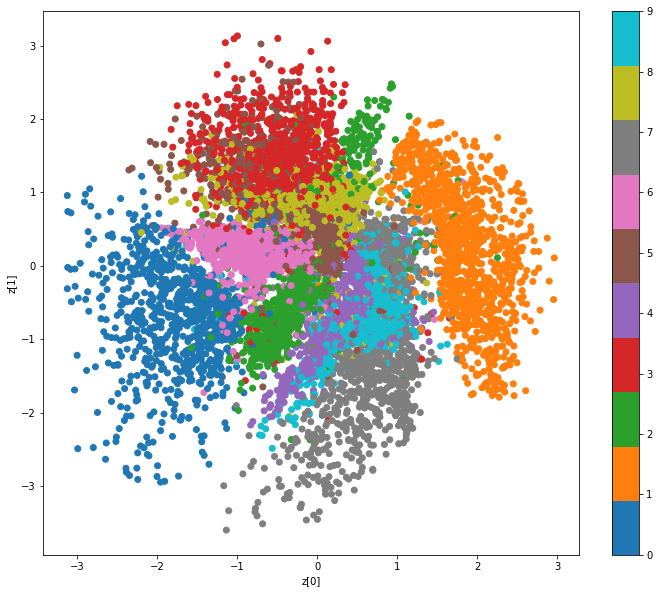

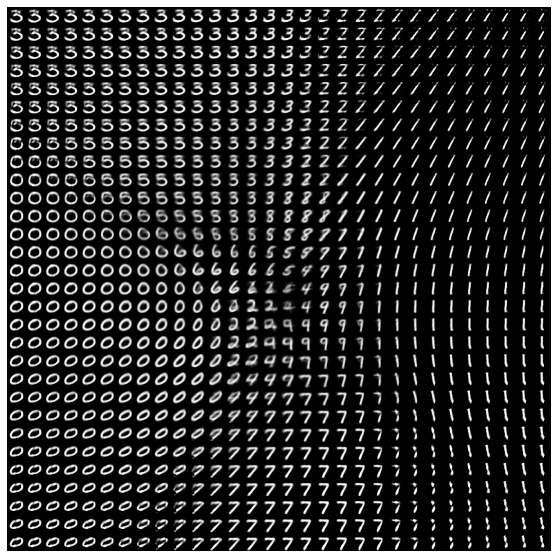

In [25]:
plot_results(encoder,
             decoder,
             x_test,
             y_test,
             batch_size=128,
             model_name="vae_mlp")

### <font color=red>B. </font>【超初心者向け】VAEの分かりやすい説明とPyTorchの実装
https://tips-memo.com/vae-pytorch

<font color=red size=5>2019.07.05時点のコード。\
可視化の記述が古いっぽくてエラー</font>

#### <font color=red>1. </font>よくある質問

##### <font color=orage>質問1. </font>モデルのどこに単位行列を仮定しているのか

デコーダの事前分布です。数式を用いれば、デコーダが条件付き確率で表される点がポイントです。\
つまり、デコーダは 
$p_\theta(x|z)$
 であって、
$p_\theta(z)$
 はデコーダの事前分布です。\
また、エンコーダ・デコーダ型のモデルでは、デコーダの事前分布を「潜在空間」と呼ぶことが多いです。\
つまり、単位行列を仮定しているのはデコーダの事前分布（潜在空間）ということになります。

##### <font color=orage>質問5. </font>潜在変数の依存関係

潜在空間はエンコーダ・デコーダの両方に依存します。\
なぜなら、エンコーダでは 
$q_\phi(z|x)$
、デコーダでは 
$p_\theta(z)$
 で $z$ が分布の式に登場しているからです。

ただし、「条件付き確率」としての依存を指している場合は、デコーダに依存します。\
条件付き確率の右側に $z$ が出てくるのはデコーダだけだからです。\
答えとしては、条件付き確率として考える場合はデコーダのみに依存、VAEの原理として捉える場合は両方に依存します。

##### <font color=orage>質問7. </font>エンコーダは高次元の空間から低次元の空間への射影なのか

概ねその通りです！\
というのも、エンコーダ・デコーダ型のモデルの意義は、低次元の潜在空間への変換だからです。\
なぜ低次元に変換するのかというと、それだけ情報が凝縮され洗練されるからです。\
この操作をニューラルネットワークさんが勝手にしてくれるというのはかなり大きいです。\
従来は主成分分析を利用して行っていましたからね…。\
オートエンコーダが主成分分析の非線型変換であると捉えられているのもそのためです。

逆に言えば、エンコーダ・デコーダ型のモデルで潜在空間を元の次元よりも大きくするようなモデルはあまり見かけません。\
（エンコーダ・デコーダ型の良さを使えないモデルになってしまいます）

##### <font color=orage>質問9. </font>潜在変数は等式で生成されるのでしょうか

はい。そういうことになります。\
ただし、本来であればエンコーダが出力したパラメータを元に$z$が自然に生成されるべきなのですが、\
「自然に生成される」というランダム操作を組み入れてしまうとニューラルネットワークの誤差伝播が途切れてしまいますので、等式「$=$」によって$z$を生成（決定）しています。\
これを「Reparameterization Trick」と呼び、VAEの発案者Kingma先生が考案された妙技です。

##### <font color=orage>質問10. </font>ギブスサンプリングはやっぱり必要なんじゃないか

ギブスサンプリングが要るか要らないか（使えるか使えないか）というのは、「モデルが誤差逆伝播によって学習しているかどうか」によって決められます。\
解析的な数式によってモデル化できる場合はギブスサンプリングする必要はありません。\
ただし、ニューラルネットワークの枠組みではまた話は違ってきます。\
例えば、ベイズ推論で事前分布に共役事前分布を設定することが多いのは、解析的にパラメータの更新式を求めるためです。\
解析的に更新式が求まれば、サンプリングの必要はなくなります。\
しかし、今回のモデルはニューラルネットワークです。\
ベイズ推論とは学習の方法が異なりますので（深層ベイズモデリングは別として）、ニューラルネットワークを誤差逆伝播で学習させる場合にはサンプリングという確率的な操作があってはならないのです。\
ですので、VAEではなくエンコーダ・デコーダ型のモデルを誤差逆伝播以外の方法で学習させる場合で、仮定した分布を解析的に解くことができないときには、サンプリングを利用するほかないと思います。\
しかし、このような状況はあまり起こりません。\
なぜなら、「サンプリングを行うしかない」という状況を作らないように研究者たちは努めているからです。

##### <font color=orage>質問11. </font>結局 $p_\theta(\hat{x})$ を知りたいってことじゃないの？

VAEの数式には $\hat{x}$ は出現しません。\
VAEの基本的なモデリングはデコーダの出力が再構成データの分布の「パラメータ」であり、再構成データそのものではないからです。\
例えば、デコーダ
$p_\theta$
 が入力データと全く異なるデータを出力したとしても、$p_\theta$ を目的関数にしてしまえばデタラメなデコーダの出力を「尤もらしい」と判断するようなモデルが完成してしまい、オートエンコーダとして成り立たなくなってしまいます。\
VAEの正しい目的関数は $p_\theta(x)$ です。\
つまり、「デコーダ分布はどれだけ入力データを確からしいと判断できるか」がVAEの目的関数ということなのです。 

##### <font color=orage>質問12. </font>Decoderの出力分布がEncoderの入力分布を”忠実に”再現するように学習するってこと？

こちらは、VAEの目的関数が $p_\theta(x)$ であることに注意すれば分かりやすいと思います。\
イメージではほぼ同じように思えますが、VAEの目的関数は入力するデータの分布と出力されるデータの分布を近づけるような目的関数ではないです。\
つまり、「Decoderの出力分布がEncoderの入力分布を”忠実に”再現する」ように学習しているのではなく、\
「Decoderの分布がEncoderの入力をどれだけ確からしいと判断するか\
（確からしいと判断できるようにデコーダを形成するのがオートエンコーダ流派の基本思想です）」\
＋「潜在空間がどれだけ仮定した分布に近づいているか」の二つの項からVAEは学習されます。

##### <font color=orage>質問14. </font>$p_\theta(x|z), p_\theta(z), p_\theta(x)$ が同じ表記なのは混乱を招くだけでは？

この三者は同じ表記ではなくてはなりません。\
なぜなら、同じニューロンを通過しているからです。\
同じ重みパラメータ $\theta$ を使って行列演算されているからです。\
ここは、ニューラルネットの特徴的な部分なのですが、対象を $x$ にするのか $z$ にするのか、はたまた $z$ に条件づけられた $x$ にするのかで、表す（裏に仮定される）分布が異なるように「できる」という点です。\
ニューラルネット、おそるべしです。\
ここを異なる表記にしてしまうと、対象が「$x$」なのか「$z$」なのか「$z$ に条件づけられた $x$」なのかで、入力するニューロンが異なるように学習させなくてはならなくなってしまいます。

##### <font color=orage>質問15. </font>$p_\theta(z)$ は $q_\phi(z|x)$ と同じなのではないか

近い分布になると思います。\
なぜなら、この2つの分布を近づけることがVAEの目標の1つだからです。\
目的関数の片方の項は 
$KL\left[q_\phi(z|x)||p_\theta(z)\right]$
ですね。\
これは2つの分布を近づけるようにVAEを学習しましょうという宣言に他なりません。

##### <font color=orage>質問19. </font>やはりデコーダ側のNNのパラメータ $\theta$ が $z$ に影響を与えるのは不可能なのではないか

デコーダは $z$ を入力として学習していきますので、入力の良さもデコーダのパラメータに影響を与えます。\
つまり、デコーダのパラメータ更新を行う中で $z$ も対応して更新されていきます。

##### <font color=orage>質問20. </font>再構成データはどのようにして生成されるのか

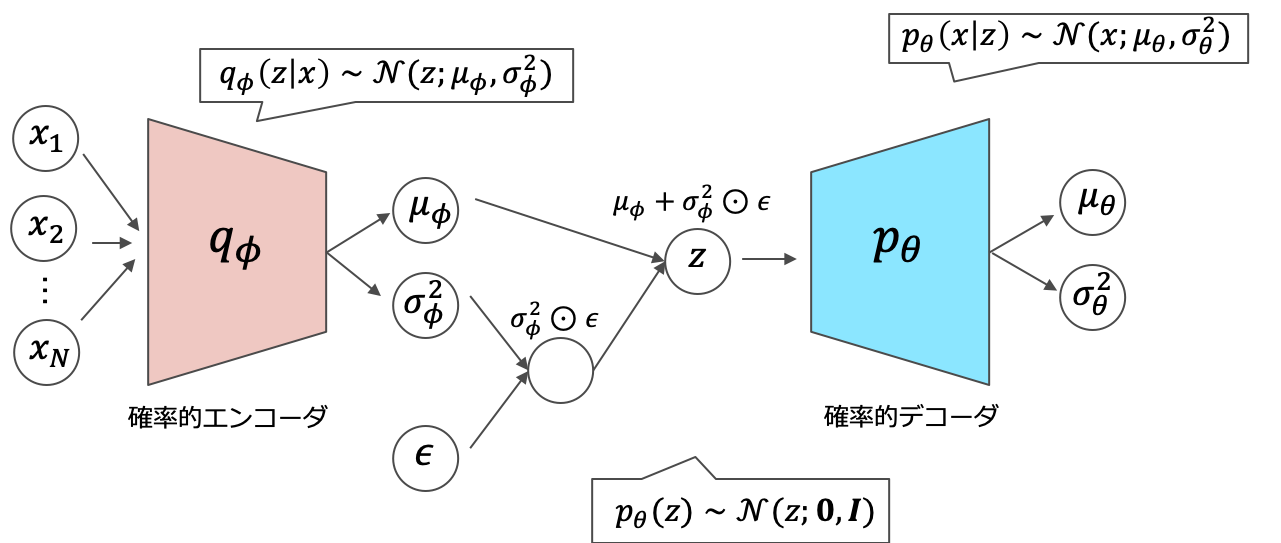

図のようにパラメータを出力する場合はサンプリングなどを利用します。\
これは、ネットワークの末端ですので誤差逆伝播には影響を与えません。\
以下のように再構成データそのものを出力する場合はデコーダの出力そのものが再構成データになります。

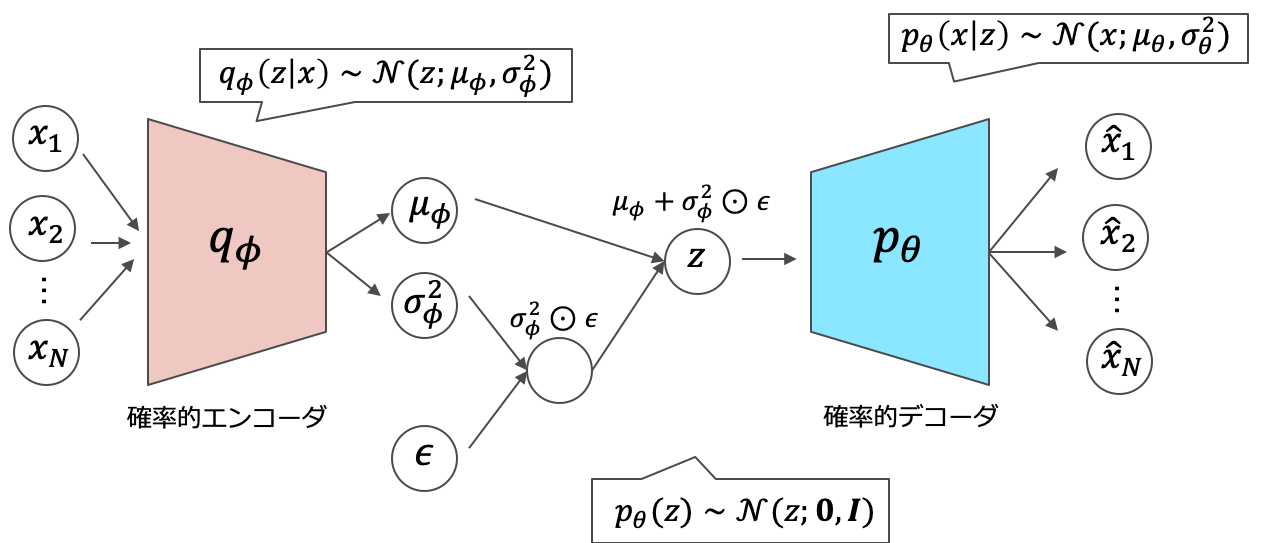

#### <font color=red>2. </font>実装

In [26]:
# 必要なライブラリのインポート

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
import torch.utils as utils
from torchvision import datasets, transforms

In [27]:
# deviceの定義

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# GPUを利用する前提でコーディングされている

In [28]:
# データセットのロード

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Lambda(lambda x: x.view(-1))])

dataset_train = datasets.MNIST(
    '~/mnist', 
    train=True, 
    download=True, 
    transform=transform)

dataset_valid = datasets.MNIST(
    '~/mnist', 
    train=False, 
    download=True, 
    transform=transform)

batch_size = 1000

dataloader_train = utils.data.DataLoader(dataset_train,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         num_workers=4)

dataloader_valid = utils.data.DataLoader(dataset_valid,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         num_workers=4)

Extracting /root/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /root/mnist/MNIST/raw


Extracting /root/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /root/mnist/MNIST/raw


Extracting /root/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/mnist/MNIST/raw


Extracting /root/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/mnist/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!





In [38]:
# ネットワークの定義

class VAE(nn.Module):

  # denseを利用した定義
  def __init__(self, x_dim, z_dim):
    super(VAE, self).__init__()
    self.x_dim = x_dim
    self.z_dim = z_dim
    self.fc1 = nn.Linear(x_dim, 20)
    self.bn1 = nn.BatchNorm1d(20)
    self.fc2_mean = nn.Linear(20, z_dim)
    self.fc2_var = nn.Linear(20, z_dim)
    self.fc3 = nn.Linear(z_dim, 20)
    self.drop1 = nn.Dropout(p=0.2)
    self.fc4 = nn.Linear(20, x_dim)

  # 潜在空間のパラメータを得るまでの定義
  def encoder(self, x):
    x = x.view(-1, self.x_dim)
    x = F.relu(self.fc1(x))
    x = self.bn1(x)
    mean = self.fc2_mean(x)
    log_var = self.fc2_var(x)
    return mean, log_var

  # エンコーダで得たパラメータからzを計算するための処理
#  def sample_z(self, mean, log_var, device):
#    epsilon = torch.randn(mean.shape, device=device)
  def sample_z(self, mean, log_var):
    epsilon = torch.randn(mean.shape)
    return mean + epsilon * torch.exp(0.5*log_var)

  # zを入力として元の次元まで再現するネットワークの定義
  def decoder(self, z):
    y = F.relu(self.fc3(z))
    y = self.drop1(y)
    y = torch.sigmoid(self.fc4(y))
    return y

  # 実際の計算機構
#  def forward(self, x, device):
  def forward(self, x):
    x = x.view(-1, self.x_dim)
    mean, log_var = self.encoder(x)
    delta = 1e-8
    KL = 0.5 * torch.sum(1 + log_var - mean**2 - torch.exp(log_var))
#    z = self.sample_z(mean, log_var, device)
    z = self.sample_z(mean, log_var)
    y = self.decoder(z)
    reconstruction = torch.mean(x * torch.log(y + delta) + (1 - x) * torch.log(1 - y + delta))
    lower_bound = [KL, reconstruction]
    return -sum(lower_bound), z, y

In [39]:
# モデルの学習

# model = VAE(x_dim=28*28, z_dim=10).to(device)
model = VAE(x_dim=28*28, z_dim=10)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

num_epochs = 20
loss_list = []

for i in range(num_epochs):
  losses = []
  for x, t in dataloader_train:
#    x = x.to(device)
#    loss, z, y = model(x, device)   # lossに変分下界の定義を記述
    loss, z, y = model(x)   # lossに変分下界の定義を記述
    model.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.cpu().detach().numpy())
  loss_list.append(np.average(losses))
  print("EPOCH: {} loss: {}".format(i, np.average(losses)))

EPOCH: 0 loss: 563.3179931640625
EPOCH: 1 loss: 64.77767944335938
EPOCH: 2 loss: 15.536401748657227
EPOCH: 3 loss: 7.053741931915283
EPOCH: 4 loss: 4.647262096405029
EPOCH: 5 loss: 3.5157690048217773
EPOCH: 6 loss: 2.7539522647857666
EPOCH: 7 loss: 2.2634589672088623
EPOCH: 8 loss: 1.9279882907867432
EPOCH: 9 loss: 1.6418436765670776
EPOCH: 10 loss: 1.5024415254592896
EPOCH: 11 loss: 1.3449108600616455
EPOCH: 12 loss: 1.1787394285202026
EPOCH: 13 loss: 1.19102942943573
EPOCH: 14 loss: 1.0099709033966064
EPOCH: 15 loss: 0.9613368511199951
EPOCH: 16 loss: 0.8631523251533508
EPOCH: 17 loss: 0.8923340439796448
EPOCH: 18 loss: 0.7788671255111694
EPOCH: 19 loss: 0.7474114298820496


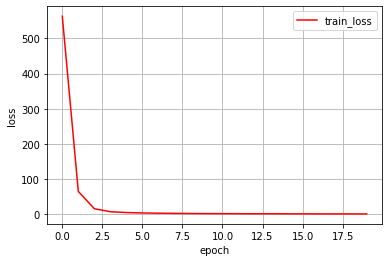

In [40]:
# グラフ描写

plt.figure()
plt.plot(range(num_epochs), loss_list, 'r-', label='train_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

RuntimeError: ignored

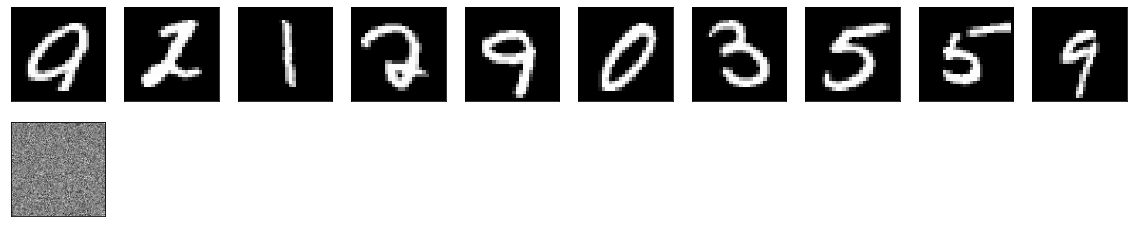

In [45]:
# 生成

fig = plt.figure(figsize=(20, 6))

model.eval()
zs = []
for x, t in dataloader_valid:
  for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
    ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

#  x = x.to(device)
#  y, z = model(x)
  loss, y, z = model(x)
  zs.append(z)
#  y = y.view(-1, 28, 28)
  y = y.view(-1, 100, 100)
  for i, im in enumerate(y.cpu().detach().numpy()[:10]):
    ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
    ax.imshow(im, 'gray')
    
#  z1to0 = torch.cat([z[1, :] * (i * 0.1) + z[0, :] * ((10 - i) * 0.1) for i in range(10)]).reshape(10, 10)
  z1to0 = torch.cat([z[1, :] * (i * 0.1) + z[0, :] * ((10 - i) * 0.1) for i in range(10)]).reshape(28, 28)
  y2 = model._decoder(z1to0).view(-1, 28, 28)
  for i, im in enumerate(y2.cpu().detach().numpy()[:20]):
    ax = fig.add_subplot(3, 10, i+21, xticks=[], yticks=[])
    ax.imshow(im, 'gray')
  break

# １行目がデータセットオリジナル
# ２行目は潜在空間から生成した画像
# 3行目は、2行目の０番目から１番目に割合を変えながら遷移させていったもの


In [34]:
# 潜在空間を可視化

from sklearn.manifold import TSNE
from random import random

colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"]

def visualize_zs(zs, labels):
  plt.figure(figsize=(10,10))
  points = TSNE(n_components=2, random_state=0).fit_transform(zs)
  for p, l in zip(points, labels):
    plt.scatter(p[0], p[1], marker="${}$".format(l), c=colors[l])
  plt.show()

model.eval()
zs = []

for x, t in dataloader_valid:
  x = x.to(device)
  t = t.to(device)
  # generate from x
  y, z = model(x)
  z = z.cpu()
  t = t.cpu()
  visualize_zs(z.detach().numpy(), t.cpu().detach().numpy())
  break

TypeError: ignored

### <font color=red>C. </font>VAE(Variational Auto Encoder)の写経
http://ni4muraano.hatenablog.com/entry/2018/01/02/220000

<font color=red size=5>2018.01.02時点のコード。\
tensorflowのコード規約大改変前につき記述が古いっぽくてエラー</font>

In [46]:
import numpy as np
from keras import Input
from keras.layers import Conv2D, Flatten, Dense, Lambda, Reshape, Conv2DTranspose, Layer
from keras.models import Model
from keras.metrics import binary_crossentropy
import keras.backend as K

import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.optimizers import RMSprop
from keras.datasets import mnist


In [47]:
class CustomVariationalLayer(Layer):
  def set_z_mean(self, z_mean):
    self._z_mean = z_mean

  def set_z_log_var(self, z_log_var):
    self._z_log_var = z_log_var

  def _vae_loss(self, x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    reconstruction_loss = binary_crossentropy(x, z_decoded)
    regularization_parameter = -5e-4 * self._compute_KL_divergence(self._z_mean, self._z_log_var)
    return K.mean(reconstruction_loss + regularization_parameter)

  def _compute_KL_divergence(self, z_mean, z_log_var):
    return K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

  def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self._vae_loss(x, z_decoded)
    self.add_loss(loss, inputs=inputs)
    return x

In [48]:
class VAE(object):
  def __init__(self, image_shape, latent_dim):
    self._latent_dim = latent_dim

    # Encoding
    input_img = Input(shape=image_shape)
    x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
    x = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    shape_before_flattening = K.int_shape(x)
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    # Sampling
    z = Lambda(self._sampling)([z_mean, z_log_var])

    # Decoding
    decoder_input = Input(K.int_shape(z)[1:])
    x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
    x = Reshape(shape_before_flattening[1:])(x)
    x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
    x = Conv2D(1, 3, padding='same', activation='sigmoid')(x)
    self._decoder = Model(inputs=decoder_input, outputs=x)
    z_decoded = self._decoder(z)
    l = CustomVariationalLayer()
    l.set_z_mean(z_mean)
    l.set_z_log_var(z_log_var)
    y = l([input_img, z_decoded])

    self._vae = Model(input_img, y)


  def _sampling(self, args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], self._latent_dim), mean=0.0, stddev=1.0)
    return z_mean + K.exp(z_log_var)*epsilon

  def get_model(self):
    return self._vae

  def get_decoder(self):
    return self._decoder

In [49]:
img_shape = (28, 28, 1)
batch_size = 32
latent_dim = 2

In [57]:
(x_train, _), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

x_train = x_train.reshape(x_train.shape+ (1,))
x_test = x_test.reshape(x_test.shape + (1,))


#image_size = x_train.shape[1] # = 784
#original_dim = image_size * image_size
#x_train = np.reshape(x_train, [-1, original_dim])
#x_test = np.reshape(x_test, [-1, original_dim])

In [58]:
vae = VAE(img_shape, latent_dim)

decoder = vae.get_decoder()

vae = vae.get_model()

vae.compile(optimizer=RMSprop(), loss=None)

history = vae.fit(x=x_train, y=None, shuffle=True, epochs=10, batch_size=batch_size)
# history = vae.fit(x_train, epochs=10, batch_size=batch_size, validation_data=(x_test, None))

with open('loss.txt', 'a') as f:
  for loss in history.history['loss']:
    f.write(str(loss) + '\r')

Epoch 1/10


_SymbolicException: ignored

In [ ]:
n = 15
digit_size = 28
figure = np.zeros((digit_size*n, digit_size*n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_y):
  for j, xi in enumerate(grid_x):
    z_sample = np.array([[xi, yi]])
    z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
    x_decoded = decoder.predict(z_sample, batch_size)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i*digit_size:(i+1)*digit_size,
           j*digit_size:(j+1)*digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

### <font color=green>D. </font>AutoencoderとVAEと。。。遊んでみた♬
https://qiita.com/MuAuan/items/cdb8ae656da60b6d89ca

#### <font color=red>1. </font>MNISTのAutoencoder

In [59]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Reshape, Embedding,InputLayer

In [65]:
def plot_fig(x_test, decoded_imgs, encoded_imgs,k):
  n = 10
  plt.figure(figsize=(10, 16))
  for j in range(0,n):
    for i in range(1,n+1):
      # display original
      ax1 = plt.subplot(20, n*1, i+10*2*j)
      ax1.imshow(x_test[i+10*j].reshape(28, 28))
      plt.gray()
      ax1.get_xaxis().set_visible(False)
      ax1.get_yaxis().set_visible(False)

      # display reconstruction
      ax2 = plt.subplot(20, n*1, i + (2*j+1)*10)
      ax2.imshow(decoded_imgs[i+10*j].reshape(28, 28))
      plt.gray()
      ax2.get_xaxis().set_visible(False)
      ax2.get_yaxis().set_visible(False)

  plt.savefig("./mnist1000/mnist_training_by_100_10_{}".format(k))    
  plt.pause(0.01)
  plt.close()

  n = 100
  plt.figure(figsize=(10, 16))
  for i in range(1,n+1):
    ax = plt.subplot(10, n*0.1, i)
    plt.imshow(encoded_imgs[i].reshape(8, 2 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

  plt.savefig("/content/mnist1000/mnist_intermid_training_by_100_10_{}".format(k))  ##
  plt.pause(0.01)
  plt.close()

In [67]:
!mkdir /content/mnist1000/

In [61]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same',name='encoded')(x)
encoder=Model(input_img, encoded)
encoder.summary()

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
encoded (MaxPooling2D)       (None, 4, 4, 8)         

In [62]:
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
encoded (MaxPooling2D)       (None, 4, 4, 8)         

In [63]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train[:1000].astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train[:1000], (len(x_train[:1000]), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
y_train=y_train[:1000]

Epoch 1/10
8/8 [==============================] - 5s 658ms/step - loss: 0.6910 - val_loss: 0.6910
Epoch 2/10
8/8 [==============================] - 5s 651ms/step - loss: 0.6910 - val_loss: 0.6909
Epoch 3/10
8/8 [==============================] - 5s 654ms/step - loss: 0.6910 - val_loss: 0.6909
Epoch 4/10
8/8 [==============================] - 5s 650ms/step - loss: 0.6909 - val_loss: 0.6909
Epoch 5/10
8/8 [==============================] - 5s 657ms/step - loss: 0.6909 - val_loss: 0.6908
Epoch 6/10
8/8 [==============================] - 5s 655ms/step - loss: 0.6909 - val_loss: 0.6908
Epoch 7/10
8/8 [==============================] - 5s 660ms/step - loss: 0.6908 - val_loss: 0.6907
Epoch 8/10
8/8 [==============================] - 5s 653ms/step - loss: 0.6908 - val_loss: 0.6907
Epoch 9/10
8/8 [==============================] - 5s 655ms/step - loss: 0.6907 - val_loss: 0.6907
Epoch 10/10
8/8 [==============================] - 5s 657ms/step - loss: 0.6907 - val_loss: 0.6906


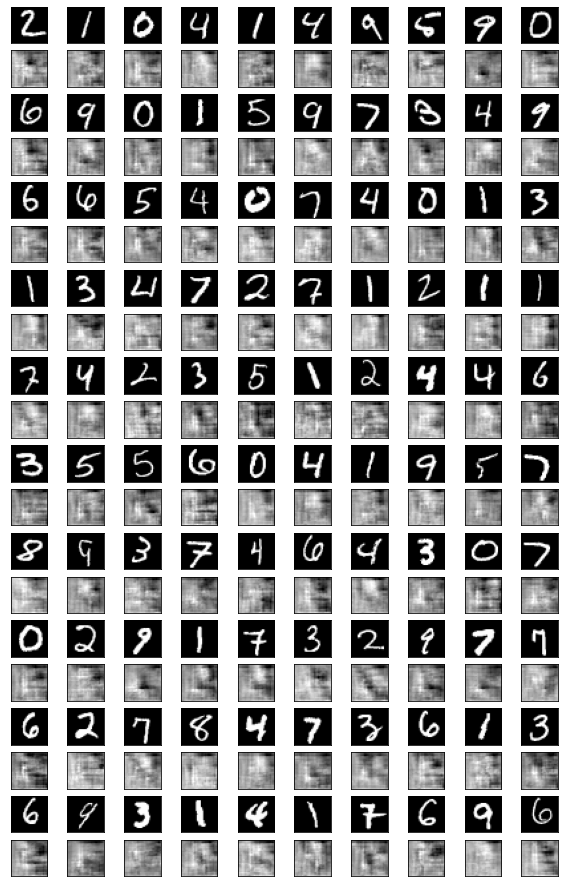

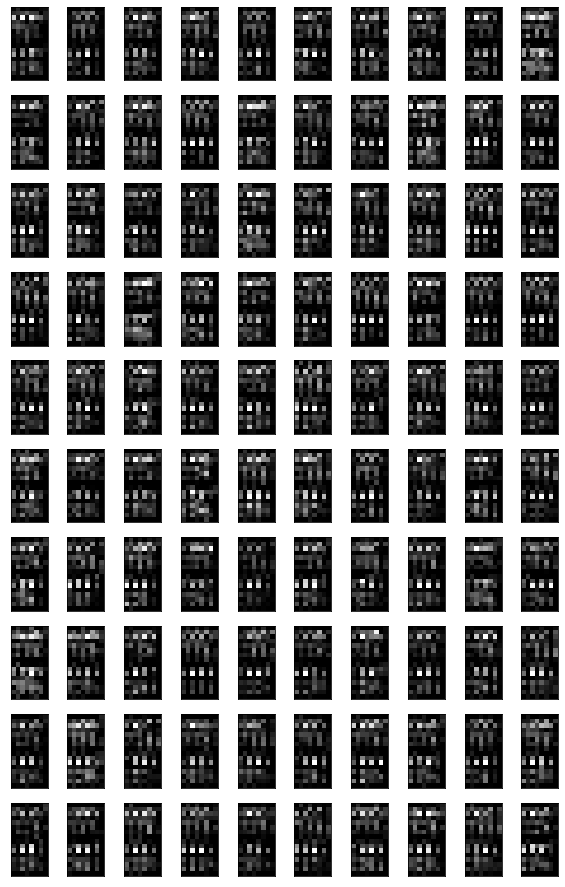

Epoch 1/10
8/8 [==============================] - 5s 652ms/step - loss: 0.6907 - val_loss: 0.6906
Epoch 2/10
8/8 [==============================] - 5s 646ms/step - loss: 0.6906 - val_loss: 0.6905
Epoch 3/10
8/8 [==============================] - 5s 650ms/step - loss: 0.6906 - val_loss: 0.6905
Epoch 4/10
8/8 [==============================] - 5s 647ms/step - loss: 0.6905 - val_loss: 0.6905
Epoch 5/10
8/8 [==============================] - 5s 650ms/step - loss: 0.6905 - val_loss: 0.6904
Epoch 6/10
8/8 [==============================] - 5s 649ms/step - loss: 0.6905 - val_loss: 0.6904
Epoch 7/10
8/8 [==============================] - 5s 650ms/step - loss: 0.6904 - val_loss: 0.6903
Epoch 8/10
8/8 [==============================] - 5s 649ms/step - loss: 0.6904 - val_loss: 0.6903
Epoch 9/10
8/8 [==============================] - 5s 648ms/step - loss: 0.6903 - val_loss: 0.6903
Epoch 10/10
8/8 [==============================] - 5s 648ms/step - loss: 0.6903 - val_loss: 0.6902


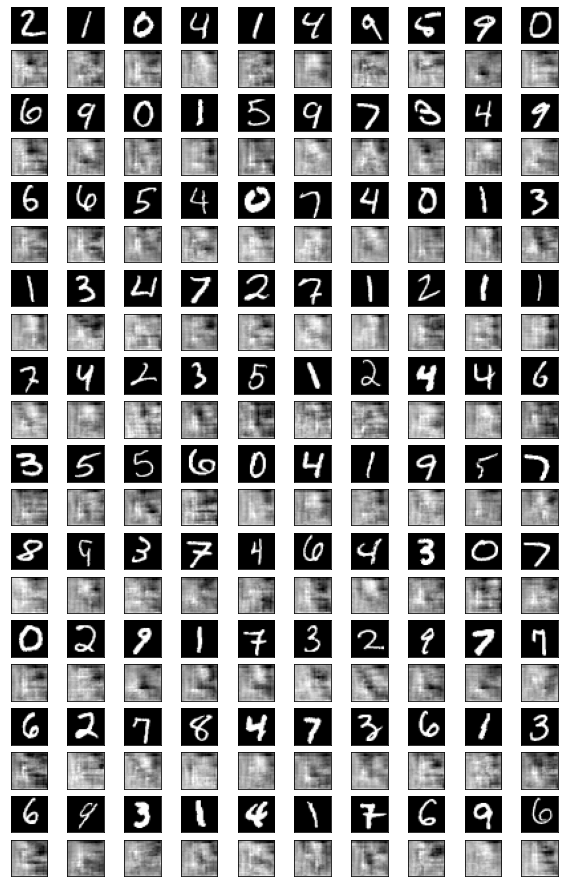

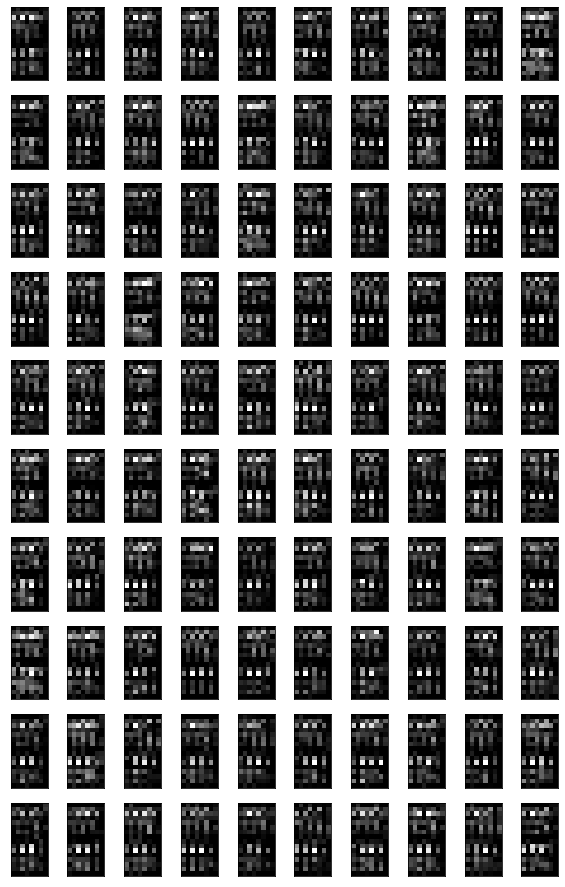

Epoch 1/10
8/8 [==============================] - 5s 650ms/step - loss: 0.6902 - val_loss: 0.6902
Epoch 2/10
8/8 [==============================] - 5s 649ms/step - loss: 0.6902 - val_loss: 0.6901
Epoch 3/10
8/8 [==============================] - 5s 650ms/step - loss: 0.6902 - val_loss: 0.6901
Epoch 4/10
8/8 [==============================] - 5s 650ms/step - loss: 0.6901 - val_loss: 0.6901
Epoch 5/10
8/8 [==============================] - 5s 645ms/step - loss: 0.6901 - val_loss: 0.6900
Epoch 6/10
8/8 [==============================] - 5s 650ms/step - loss: 0.6900 - val_loss: 0.6900
Epoch 7/10
8/8 [==============================] - 5s 647ms/step - loss: 0.6900 - val_loss: 0.6899
Epoch 8/10
8/8 [==============================] - 5s 649ms/step - loss: 0.6899 - val_loss: 0.6899
Epoch 9/10
8/8 [==============================] - 5s 651ms/step - loss: 0.6899 - val_loss: 0.6898
Epoch 10/10
8/8 [==============================] - 5s 655ms/step - loss: 0.6899 - val_loss: 0.6898


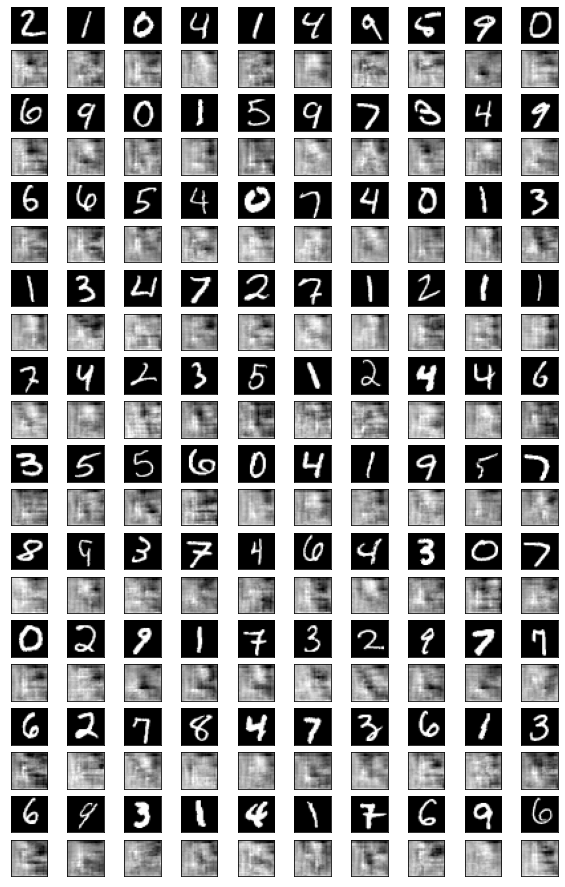

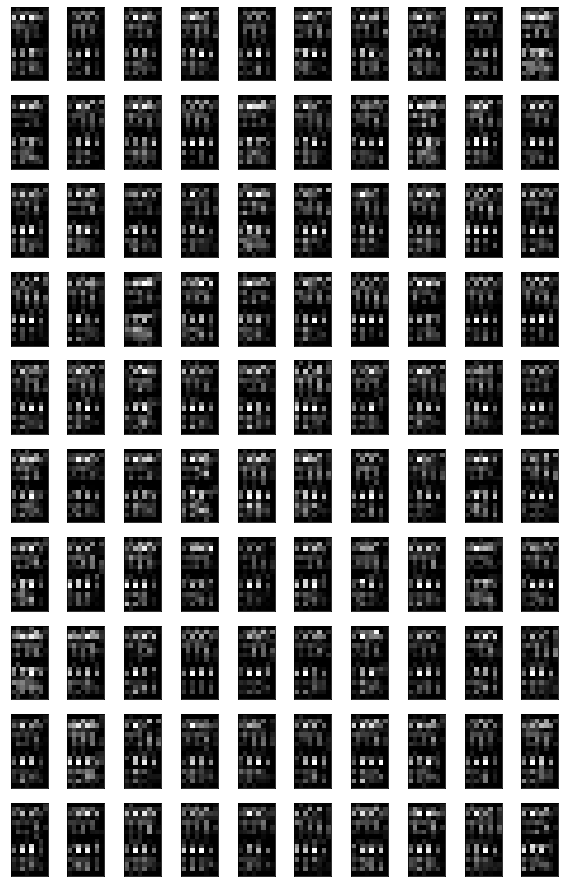

Epoch 1/10
8/8 [==============================] - 5s 649ms/step - loss: 0.6898 - val_loss: 0.6897
Epoch 2/10
8/8 [==============================] - 5s 648ms/step - loss: 0.6898 - val_loss: 0.6897
Epoch 3/10
8/8 [==============================] - 5s 644ms/step - loss: 0.6897 - val_loss: 0.6896
Epoch 4/10
8/8 [==============================] - 5s 647ms/step - loss: 0.6897 - val_loss: 0.6896
Epoch 5/10
8/8 [==============================] - 5s 646ms/step - loss: 0.6896 - val_loss: 0.6896
Epoch 6/10
8/8 [==============================] - 5s 647ms/step - loss: 0.6896 - val_loss: 0.6895
Epoch 7/10
8/8 [==============================] - 5s 643ms/step - loss: 0.6895 - val_loss: 0.6895
Epoch 8/10
8/8 [==============================] - 5s 647ms/step - loss: 0.6895 - val_loss: 0.6894
Epoch 9/10
8/8 [==============================] - 5s 646ms/step - loss: 0.6894 - val_loss: 0.6894
Epoch 10/10
8/8 [==============================] - 5s 643ms/step - loss: 0.6894 - val_loss: 0.6893


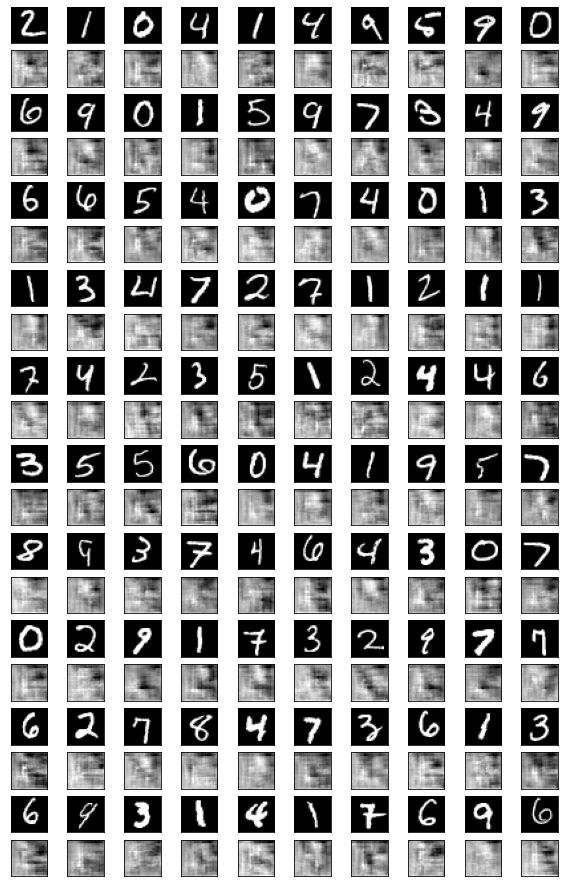

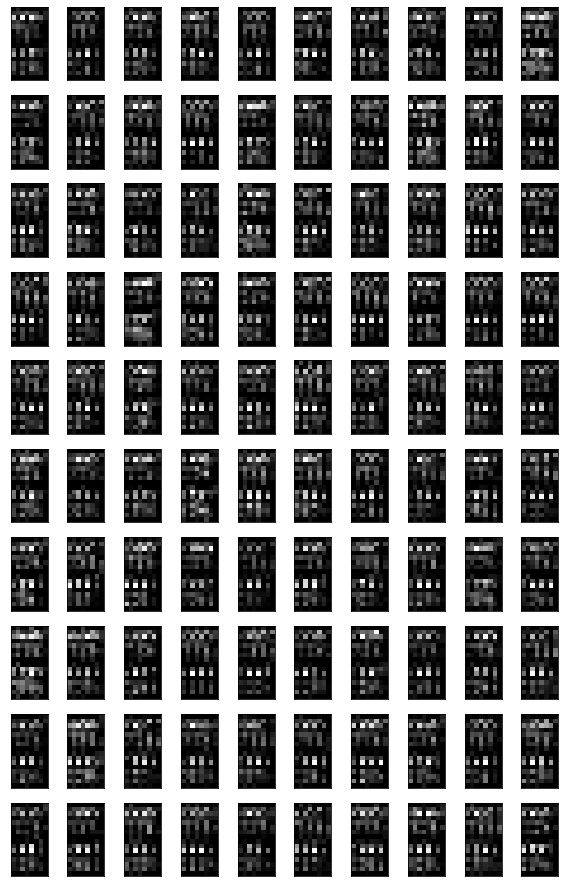

Epoch 1/10
8/8 [==============================] - 5s 653ms/step - loss: 0.6893 - val_loss: 0.6893
Epoch 2/10
8/8 [==============================] - 5s 662ms/step - loss: 0.6893 - val_loss: 0.6892
Epoch 3/10
8/8 [==============================] - 5s 656ms/step - loss: 0.6892 - val_loss: 0.6892
Epoch 4/10
8/8 [==============================] - 5s 650ms/step - loss: 0.6892 - val_loss: 0.6891
Epoch 5/10
8/8 [==============================] - 5s 645ms/step - loss: 0.6891 - val_loss: 0.6891
Epoch 6/10
8/8 [==============================] - 5s 644ms/step - loss: 0.6891 - val_loss: 0.6890
Epoch 7/10
8/8 [==============================] - 5s 643ms/step - loss: 0.6890 - val_loss: 0.6890
Epoch 8/10
8/8 [==============================] - 5s 646ms/step - loss: 0.6890 - val_loss: 0.6889
Epoch 9/10
8/8 [==============================] - 5s 645ms/step - loss: 0.6889 - val_loss: 0.6889
Epoch 10/10
8/8 [==============================] - 5s 650ms/step - loss: 0.6889 - val_loss: 0.6888


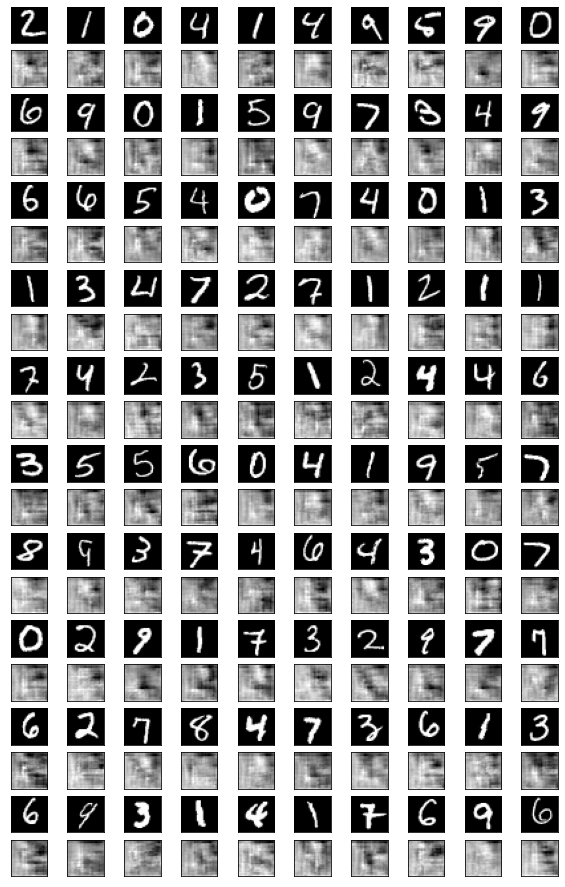

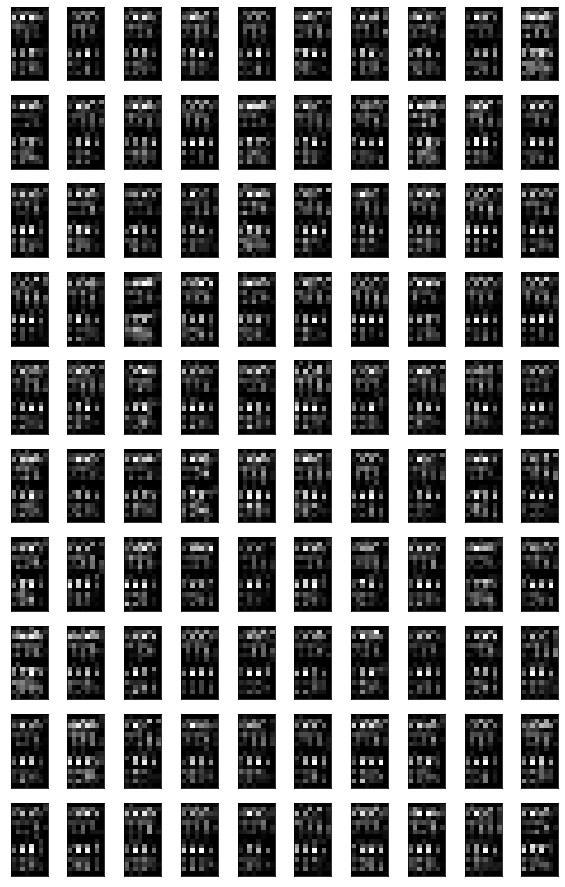

Epoch 1/10
8/8 [==============================] - 5s 655ms/step - loss: 0.6888 - val_loss: 0.6888
Epoch 2/10
8/8 [==============================] - 5s 653ms/step - loss: 0.6888 - val_loss: 0.6887
Epoch 3/10
8/8 [==============================] - 5s 648ms/step - loss: 0.6887 - val_loss: 0.6887
Epoch 4/10
8/8 [==============================] - 5s 647ms/step - loss: 0.6887 - val_loss: 0.6886
Epoch 5/10
8/8 [==============================] - 5s 651ms/step - loss: 0.6886 - val_loss: 0.6886
Epoch 6/10
8/8 [==============================] - 5s 648ms/step - loss: 0.6886 - val_loss: 0.6885
Epoch 7/10
8/8 [==============================] - 5s 651ms/step - loss: 0.6885 - val_loss: 0.6884
Epoch 8/10
8/8 [==============================] - 5s 649ms/step - loss: 0.6885 - val_loss: 0.6884
Epoch 9/10
8/8 [==============================] - 5s 648ms/step - loss: 0.6884 - val_loss: 0.6883
Epoch 10/10
8/8 [==============================] - 5s 646ms/step - loss: 0.6883 - val_loss: 0.6883


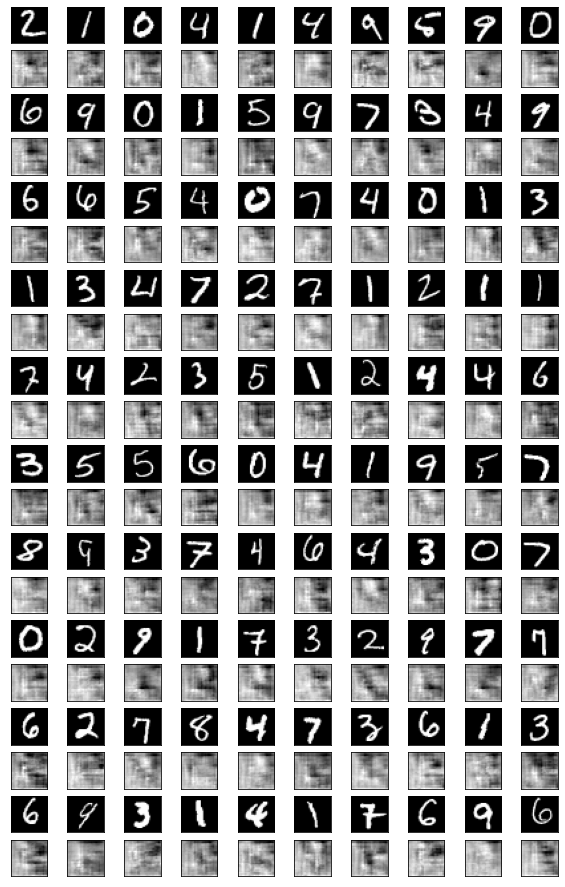

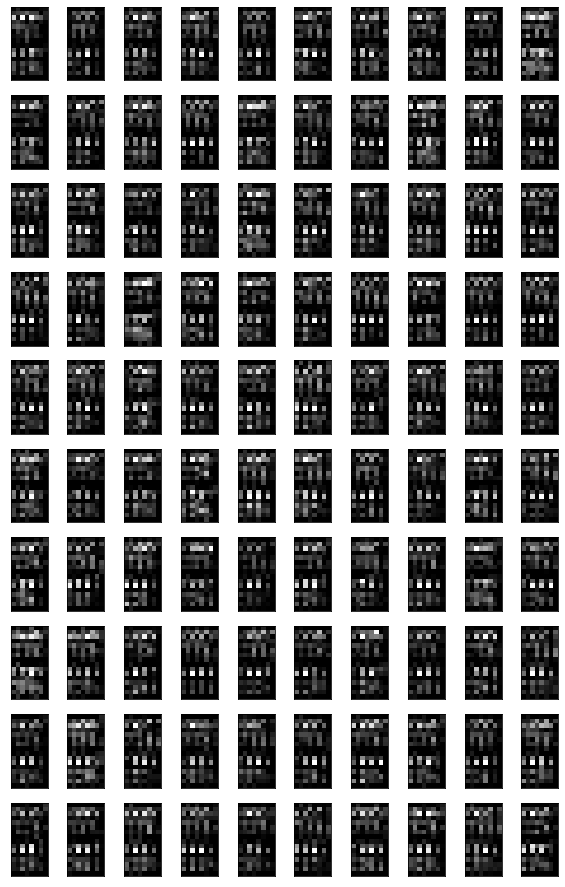

Epoch 1/10
8/8 [==============================] - 5s 651ms/step - loss: 0.6883 - val_loss: 0.6882
Epoch 2/10
8/8 [==============================] - 5s 651ms/step - loss: 0.6882 - val_loss: 0.6882
Epoch 3/10
8/8 [==============================] - 5s 651ms/step - loss: 0.6882 - val_loss: 0.6881
Epoch 4/10
8/8 [==============================] - 5s 645ms/step - loss: 0.6881 - val_loss: 0.6881
Epoch 5/10
8/8 [==============================] - 5s 647ms/step - loss: 0.6881 - val_loss: 0.6880
Epoch 6/10
8/8 [==============================] - 5s 644ms/step - loss: 0.6880 - val_loss: 0.6879
Epoch 7/10
8/8 [==============================] - 5s 648ms/step - loss: 0.6879 - val_loss: 0.6879
Epoch 8/10
8/8 [==============================] - 5s 650ms/step - loss: 0.6879 - val_loss: 0.6878
Epoch 9/10
8/8 [==============================] - 5s 650ms/step - loss: 0.6878 - val_loss: 0.6878
Epoch 10/10
8/8 [==============================] - 5s 650ms/step - loss: 0.6878 - val_loss: 0.6877


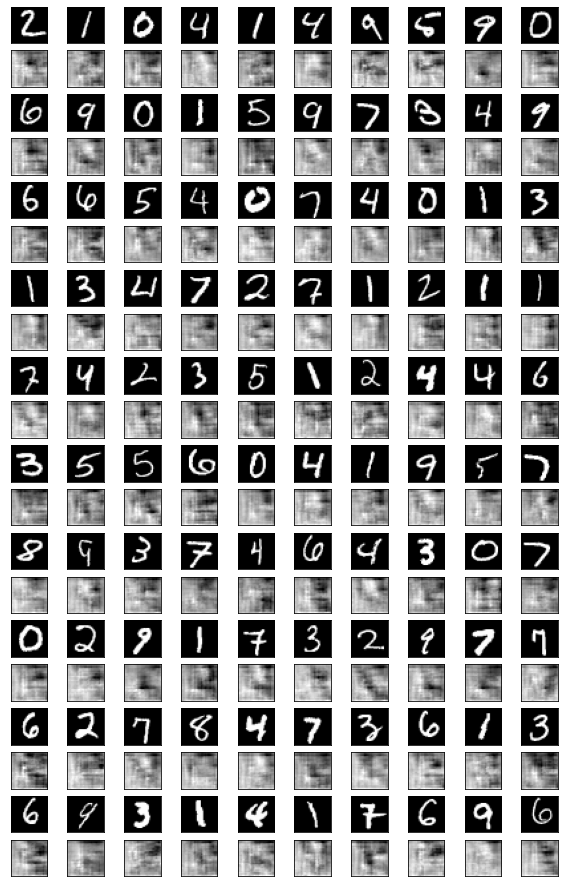

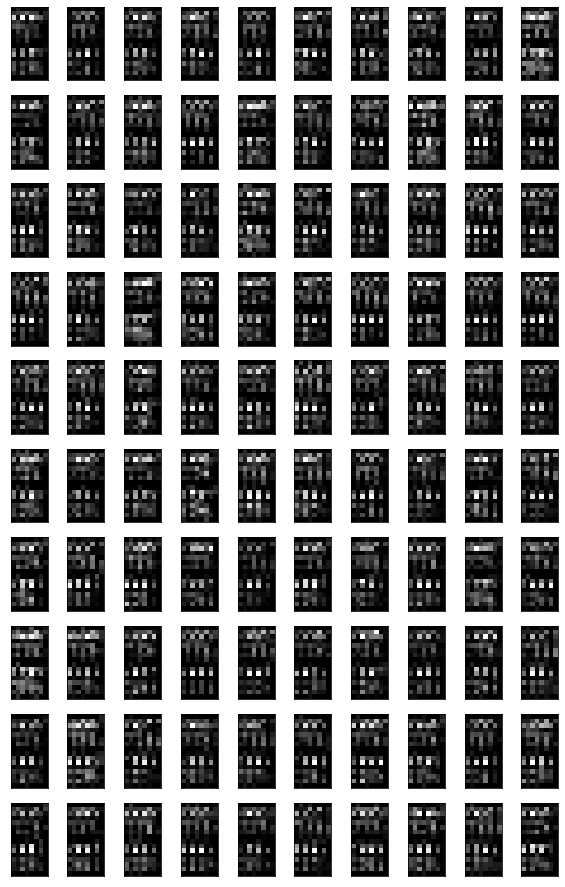

Epoch 1/10
8/8 [==============================] - 5s 655ms/step - loss: 0.6877 - val_loss: 0.6876
Epoch 2/10
8/8 [==============================] - 5s 654ms/step - loss: 0.6876 - val_loss: 0.6876
Epoch 3/10
8/8 [==============================] - 5s 651ms/step - loss: 0.6876 - val_loss: 0.6875
Epoch 4/10
8/8 [==============================] - 5s 648ms/step - loss: 0.6875 - val_loss: 0.6874
Epoch 5/10
8/8 [==============================] - 5s 650ms/step - loss: 0.6874 - val_loss: 0.6874
Epoch 6/10
8/8 [==============================] - 5s 649ms/step - loss: 0.6874 - val_loss: 0.6873
Epoch 7/10
8/8 [==============================] - 5s 656ms/step - loss: 0.6873 - val_loss: 0.6873
Epoch 8/10
8/8 [==============================] - 5s 656ms/step - loss: 0.6872 - val_loss: 0.6872
Epoch 9/10
8/8 [==============================] - 5s 659ms/step - loss: 0.6872 - val_loss: 0.6871
Epoch 10/10
8/8 [==============================] - 5s 653ms/step - loss: 0.6871 - val_loss: 0.6871


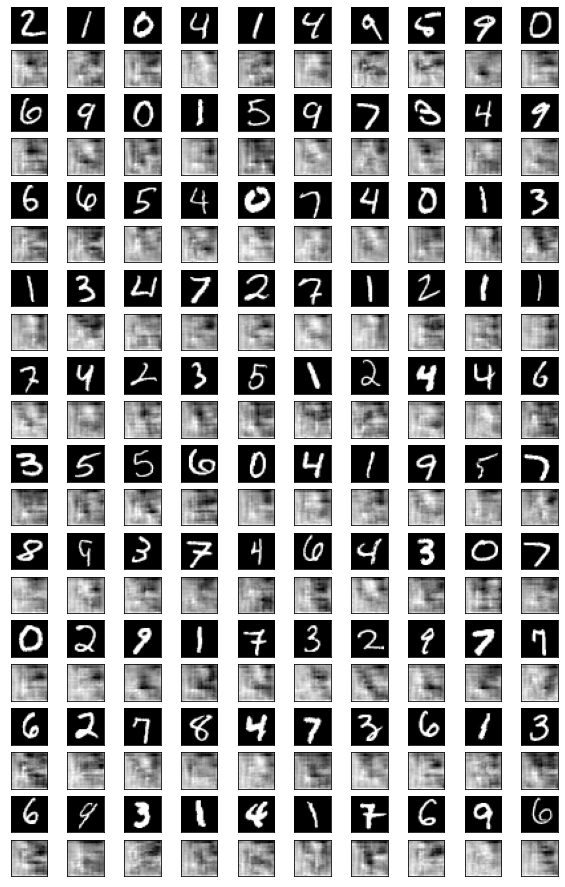

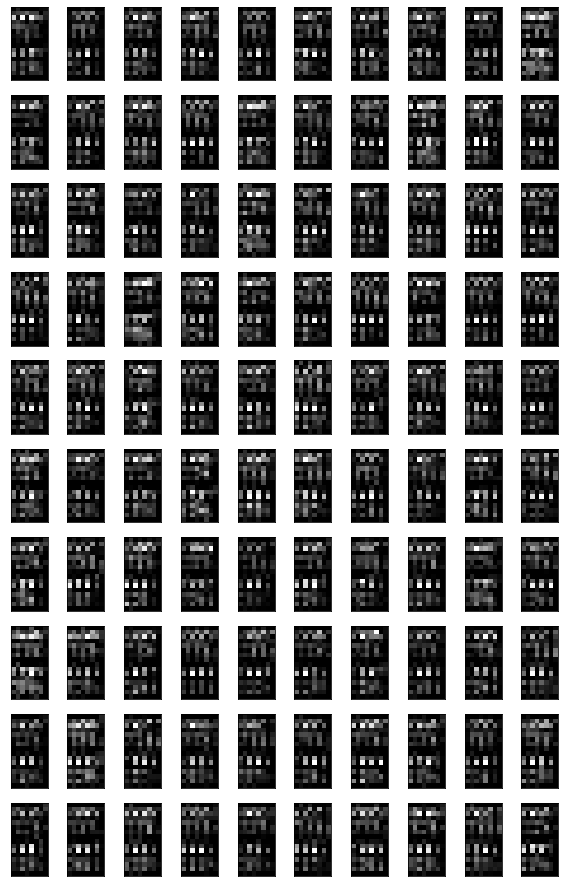

Epoch 1/10
8/8 [==============================] - 5s 651ms/step - loss: 0.6870 - val_loss: 0.6870
Epoch 2/10
8/8 [==============================] - 5s 659ms/step - loss: 0.6870 - val_loss: 0.6869
Epoch 3/10
8/8 [==============================] - 5s 653ms/step - loss: 0.6869 - val_loss: 0.6869
Epoch 4/10
8/8 [==============================] - 5s 647ms/step - loss: 0.6868 - val_loss: 0.6868
Epoch 5/10
8/8 [==============================] - 5s 664ms/step - loss: 0.6868 - val_loss: 0.6867
Epoch 6/10
8/8 [==============================] - 5s 663ms/step - loss: 0.6867 - val_loss: 0.6866
Epoch 7/10
8/8 [==============================] - 5s 648ms/step - loss: 0.6866 - val_loss: 0.6866
Epoch 8/10
8/8 [==============================] - 5s 649ms/step - loss: 0.6866 - val_loss: 0.6865
Epoch 9/10
8/8 [==============================] - 5s 649ms/step - loss: 0.6865 - val_loss: 0.6864
Epoch 10/10
8/8 [==============================] - 5s 642ms/step - loss: 0.6864 - val_loss: 0.6864


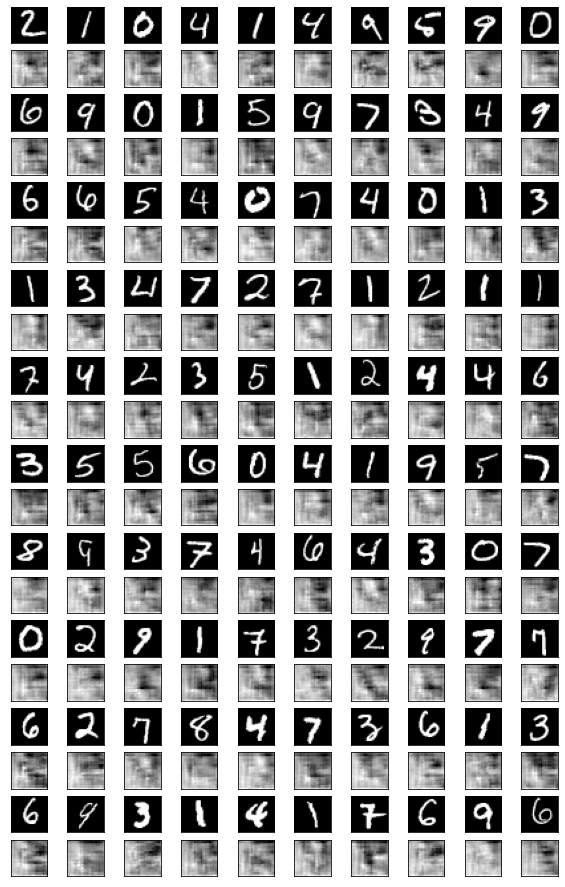

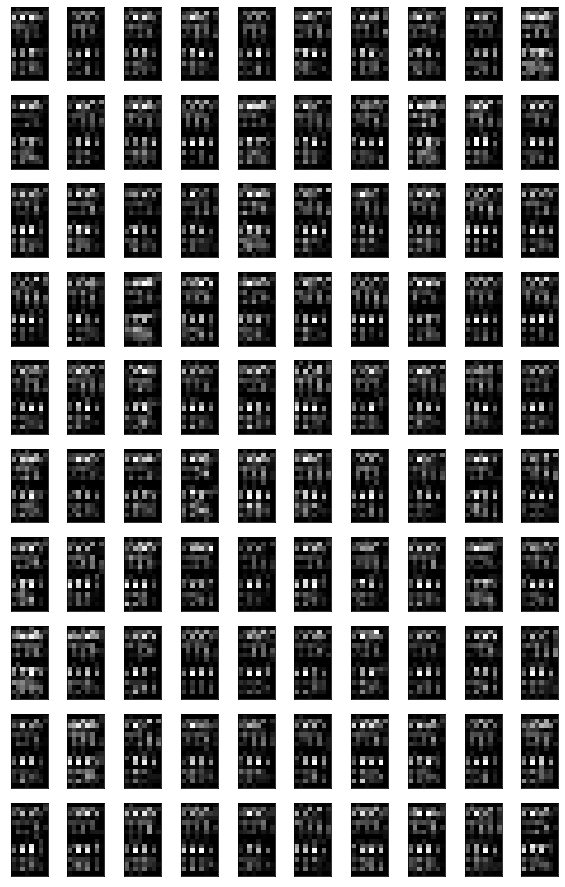

Epoch 1/10
8/8 [==============================] - 5s 652ms/step - loss: 0.6863 - val_loss: 0.6863
Epoch 2/10
8/8 [==============================] - 5s 648ms/step - loss: 0.6863 - val_loss: 0.6862
Epoch 3/10
8/8 [==============================] - 5s 646ms/step - loss: 0.6862 - val_loss: 0.6861
Epoch 4/10
8/8 [==============================] - 5s 653ms/step - loss: 0.6861 - val_loss: 0.6861
Epoch 5/10
8/8 [==============================] - 5s 650ms/step - loss: 0.6860 - val_loss: 0.6860
Epoch 6/10
8/8 [==============================] - 5s 653ms/step - loss: 0.6860 - val_loss: 0.6859
Epoch 7/10
8/8 [==============================] - 5s 650ms/step - loss: 0.6859 - val_loss: 0.6858
Epoch 8/10
8/8 [==============================] - 5s 649ms/step - loss: 0.6858 - val_loss: 0.6858
Epoch 9/10
8/8 [==============================] - 5s 653ms/step - loss: 0.6857 - val_loss: 0.6857
Epoch 10/10
8/8 [==============================] - 5s 651ms/step - loss: 0.6856 - val_loss: 0.6856


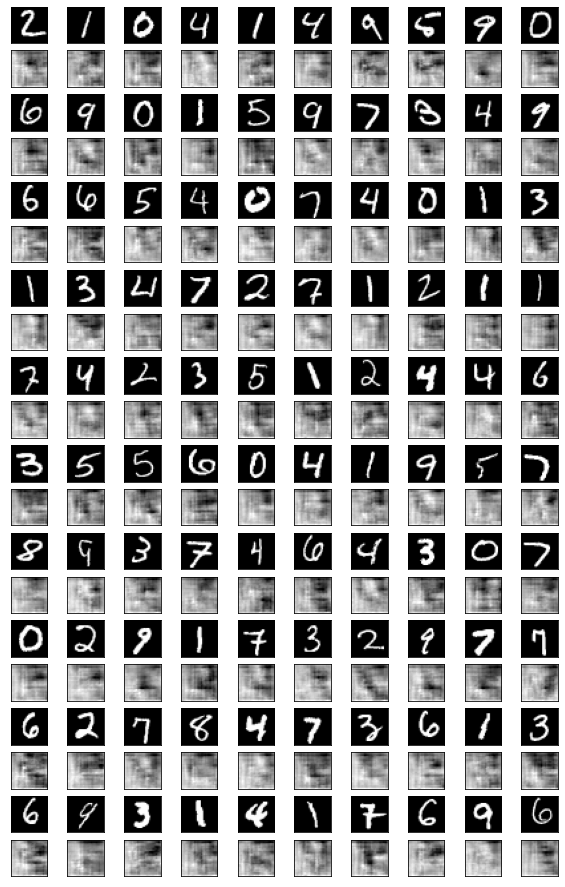

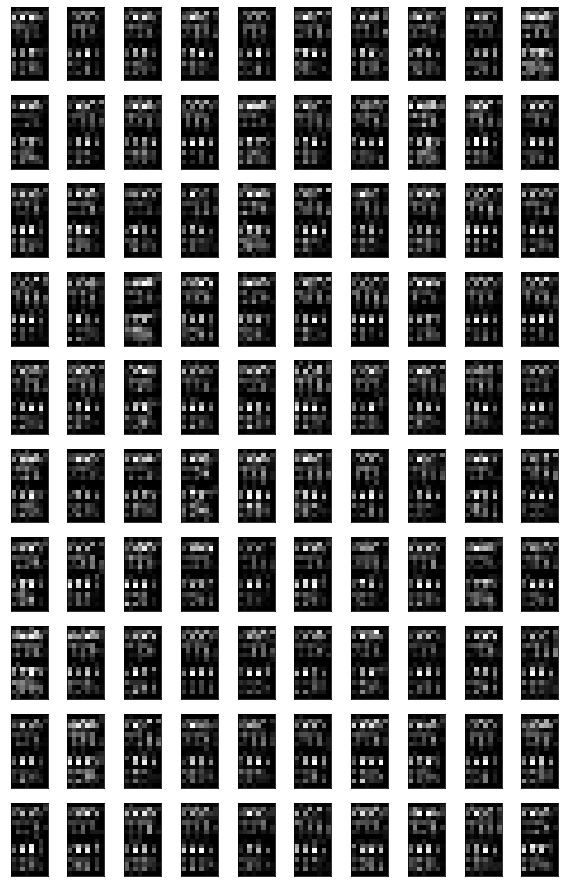

In [68]:
for j in range(10):
  x_train1 = x_train
  x_test1 = x_test

  autoencoder.fit(x_train1, x_train1,
                  epochs=10,
                  batch_size=128,
                  shuffle=True,
                  validation_data=(x_test1, x_test1)
                  )

  decoded_imgs = autoencoder.predict(x_test)
  encoded_imgs = encoder.predict(x_test)
  
  plot_fig(x_test,decoded_imgs,encoded_imgs,j)

#### <font color=red>2. </font>MNISTのVAE

In [69]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import cv2

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dropout, Activation, Flatten
from keras.layers import Reshape, Embedding,InputLayer

In [70]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
  """Reparameterization trick by sampling fr an isotropic unit Gaussian.
  # Arguments
      args (tensor): mean and log of variance of Q(z|X)
  # Returns
      z (tensor): sampled latent vector
  """
  z_mean, z_log_var = args
  batch = K.shape(z_mean)[0]
  dim = K.int_shape(z_mean)[1]
  # by default, random_normal has mean=0 and std=1.0
  epsilon = K.random_normal(shape=(batch, dim))
  return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [71]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
  """Plots labels and MNIST digits as function of 2-dim latent vector
  # Arguments
      models (tuple): encoder and decoder models
      data (tuple): test data and label
      batch_size (int): prediction batch size
      model_name (string): which model is using this function
  """
  encoder, decoder = models
  x_test, y_test = data
  os.makedirs(model_name, exist_ok=True)

  filename1 = "/content/mnist1000/vae_mean_all.png"  ##
  # display a 2D plot of the digit classes in the latent space
  z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
  plt.figure(figsize=(12, 10))
  plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
  plt.colorbar()
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.savefig(filename1)
  plt.show()

  filename2 = "/content/mnist1000/digits_over_latent_all.png"  ##
  # display a 30x30 2D manifold of digits
  n = 30
  digit_size = 28
  figure = np.zeros((digit_size * n, digit_size * n))
  # linearly spaced coordinates corresponding to the 2D plot
  # of digit classes in the latent space
  grid_x = np.linspace(-4, 4, n)
  grid_y = np.linspace(-4, 4, n)[::-1]

  for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
      z_sample = np.array([[xi, yi]])
      x_decoded = decoder.predict(z_sample)
      digit = x_decoded[0].reshape(digit_size, digit_size)
      figure[i * digit_size: (i + 1) * digit_size,
             j * digit_size: (j + 1) * digit_size] = digit

  plt.figure(figsize=(10, 10))
  start_range = digit_size // 2
  end_range = n * digit_size + start_range + 1
  pixel_range = np.arange(start_range, end_range, digit_size)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.imshow(figure, cmap='Greys_r')
  plt.savefig(filename2)
  plt.show()

In [72]:
def plot_results2(models,
                  data,
                  batch_size=128,
                  model_name="vae_mnist"):
  z0=[-0.7,-3]
  z7=[-0.7,2]
  for t in range(50):
    s=t/50
    z_sample=np.array([[s*(-0.7)+(1-s)*(-0.7),s*(-3)+(1-s)*2]])
    x_decoded = decoder.predict(z_sample)
    plt.imshow(x_decoded.reshape(28, 28))
    plt.title("z_sample="+str(z_sample))
    plt.savefig('/content/mnist1000/z_sample_t{}'.format(t)) ##
    plt.show()
    plt.close()

In [73]:
# MNIST dataset
#(x_train, _), (x_test, _) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = mnist.load_data()
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = x_train[:60000].astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train[:60000], (len(x_train[:60000]), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 
y_train=y_train[:60000]

In [74]:
# network parameters
#input_shape = (original_dim, )
input_shape = (image_size, image_size, 1)
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 100

In [75]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same',name='encoded')(x)
shape = K.int_shape(x)
print("shape[1], shape[2], shape[3]",shape[1], shape[2], shape[3])
x = Flatten()(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

shape[1], shape[2], shape[3] 4 4 8
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 28, 28, 16)   160         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 16)   0           conv2d_32[0][0]                  
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 14, 14, 8)    1160        max_pooling2d_2[0][0]            
_________________________________________________________

In [76]:
# build decoder model
# decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_39 (Dense)             (None, 128)               384       
_________________________________________________________________
reshape_5 (Reshape)          (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 8, 8, 8)           584       
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 16, 16, 8)         0   

In [77]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

# loss関数
# Compute VAE loss
reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                          K.flatten(outputs))
reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [80]:
x_train1 = x_train
x_test1 = x_test

#vae.load_weights('vae_mnist_weights_100.h5')
#encoder.load_weights('encoder_mnist_weights_100.h5')
#decoder.load_weights('decoder_mnist_weights_100.h5')

In [81]:
# autoencoderの実行
vae.fit(x_train1,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test1, None))

models = (encoder, decoder)
data = (x_test, y_test)

plot_results(models,
             data,
             batch_size=batch_size,
             model_name="vae_mlp")

plot_results2(models,
              data,
              batch_size=batch_size,
              model_name="vae_mlp")

vae.save_weights('vae_mnist_weights_100.h5')
encoder.save_weights('encoder_mnist_weights_100.h5')
decoder.save_weights('decoder_mnist_weights_100.h5')

Epoch 1/100
469/469 [==============================] - 103s 221ms/step - loss: 218.1543 - val_loss: 181.2380
Epoch 2/100
469/469 [==============================] - 105s 223ms/step - loss: 176.6113 - val_loss: 173.9147
Epoch 3/100
469/469 [==============================] - 104s 221ms/step - loss: 171.5601 - val_loss: 169.8026
Epoch 4/100
469/469 [==============================] - 104s 223ms/step - loss: 168.5184 - val_loss: 167.0194
Epoch 5/100
469/469 [==============================] - 105s 223ms/step - loss: 166.5274 - val_loss: 165.4369
Epoch 6/100
469/469 [==============================] - 104s 222ms/step - loss: 165.1472 - val_loss: 164.3378
Epoch 7/100
469/469 [==============================] - 104s 223ms/step - loss: 164.1053 - val_loss: 163.5868
Epoch 8/100
469/469 [==============================] - 105s 223ms/step - loss: 163.2516 - val_loss: 162.6047
Epoch 9/100
469/469 [==============================] - 104s 222ms/step - loss: 162.6732 - val_loss: 162.0966
Epoch 10/100
469/46

KeyboardInterrupt: ignored

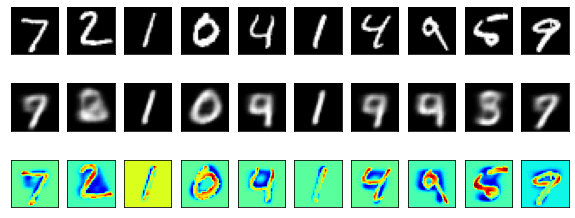

In [82]:
# 実行結果の表示
n = 10
decoded_imgs = vae.predict(x_test[:n])

plt.figure(figsize=(10, 4))
for i in range(n):
  # original_image
  orig_img = x_test[i].reshape(image_size, image_size)

  # reconstructed_image
  reconst_img = decoded_imgs[i].reshape(image_size, image_size)

  # diff image
  diff_img = ((orig_img - reconst_img)+2)/4
  diff_img = (diff_img*255).astype(np.uint8)
  orig_img = (orig_img*255).astype(np.uint8)
  reconst_img = (reconst_img*255).astype(np.uint8)
  diff_img_color = cv2.applyColorMap(diff_img, cv2.COLORMAP_JET)

  # display original
  ax = plt.subplot(3, n,  i + 1)
  plt.imshow(orig_img, cmap=plt.cm.gray)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(3, n, i + n + 1)
  plt.imshow(reconst_img, cmap=plt.cm.gray)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display diff
  ax = plt.subplot(3, n, i + n*2 + 1)
  plt.imshow(diff_img, cmap=plt.cm.jet)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.savefig("autodetect_all.jpg")
plt.pause(1)
plt.close()

In [ ]:
# 学習結果の保存
vae.save('./ae_mnist.h5')

# json and weights
model_json = vae.to_json()
with open('ae_mnist.json', 'w') as json_file:
  json_file.write(model_json)
vae.save_weights('ae_mnist_weights.h5')

#### <font color=red>3. </font>異常検知について

In [ ]:
## 以下のコードのように学習を７のみに限定して学習すると、
## そのz空間での様子を見るとほぼ全領域で７のような形状になっています

# 学習に使うデータを限定する
x_train1 = x_train[y_train==7]
x_test1 = x_test[y_test==7]

vae.fit(x_train1,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test1, None))

### <font color=green>E. </font>教師なし機械学習「VAE」による連続的な手書き文字の生成
https://rightcode.co.jp/blog/information-technology/unsupervised-learning-vae-continuous-handwriting-generation

<font color=red size=5>2020.08.13時点のコード。Colaboratory想定ではない</font>

In [83]:
import torch
import torchvision
 
import torchvision.datasets as dset
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from mpl_toolkits.mplot3d import axes3d
from torchvision.datasets import MNIST
import torch.nn.functional as F
import os
import pylab
import math
import matplotlib.pyplot as plt

In [ ]:
#gpuデバイスがあるならgpuを使う
#ないならcpuで
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [88]:
#カレントディレクトリにdc_imgというフォルダが作られる
if not os.path.exists('./dc_img'):
    os.mkdir('./dc_img')
    
#カレントディレクトリにdataというフォルダが作られる
if not os.path.exists('./data'):
    os.mkdir('./data')

In [85]:
num_epochs = 5  #エポック数 
batch_size = 30  #バッチサイズ
learning_rate = 1e-3   #学習率
 
train = True #Trueなら訓練用データ、Falseなら検証用データを使う
pretrained = False #学習済みのモデルを使うときはここをTrueに
latent_dim = 2  #最終的に落とし込む次元数
save_img = True   #元画像と再構成画像を保存するかどうか、バッチサイズが大きいときは保存しない方がいい

In [86]:
def to_img(x):
  x = x
  x = x.clamp(0, 1)
    
  return x

In [87]:
#画像データを前処理する関数
transform = transforms.Compose(
    [transforms.RandomResizedCrop(32, scale=(1.0, 1.0), ratio=(1., 1.)),
     transforms.ToTensor(),]
     )

In [89]:
#このコードで自動で./data/以下にm-nistデータがダウンロードされる
trainset = torchvision.datasets.MNIST(root='./data/',
                                      train=True,
                                      download=True,
                                      transform=transform)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [90]:
#このコードで自動で./data/以下にm-nistデータがダウンロードされる
testset = torchvision.datasets.MNIST(root='./data/',
                                     train=False, 
                                     download=True, 
                                     transform=transform)

In [91]:
#学習時なら訓練用データを用いる
if train:
  dataloader = DataLoader(trainset,
                          batch_size=batch_size,
                          shuffle=True)
#テスト時なら検証用データを用いる
else:
  dataloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [92]:
#ネットワーク定義
class VAE(nn.Module):
  def __init__(self, z_dim):
    super(VAE, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(1, 64, 3, stride=1, padding=1),  # b, 64, 32, 32
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0,True),            
        nn.MaxPool2d(2)  # b, 64, 16, 16
        )
        
    self.conv2 = nn.Sequential(
        nn.Conv2d(64, 128, 3, stride=1, padding=1),  # b, 128, 16, 16
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0,True),            
        nn.MaxPool2d(2)  # b, 128, 8, 8
        )
        
    self.conv3 = nn.Sequential(
        nn.Conv2d(128, 256, 3, stride=1, padding=1),  # b, 256, 8, 8
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0,True),            
        nn.MaxPool2d(2)  # b, 256, 4, 4
        )
        
    self.conv4 = nn.Sequential(
        nn.Conv2d(256, 512, 4, stride=1, padding=0),  # b, 512, 1, 1
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0,True),
        )

    self.mean = nn.Sequential(
        nn.Linear(512,latent_dim),  # b, 512 ==> b, latent_dim
        )
        
    self.var = nn.Sequential(
        nn.Linear(512,latent_dim),  # b, 512 ==> b, latent_dim
        )

    self.decoder = nn.Sequential(
        nn.Linear(latent_dim,512),  # b, latent_dim ==> b, 512
        nn.BatchNorm1d(512),
        nn.LeakyReLU(0,True),
        )
    
    self.convTrans1 = nn.Sequential(
        nn.ConvTranspose2d(512, 256, 4, stride=2,padding = 0),  # b, 256, 4, 4
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0,True),
        )
    
    self.convTrans2 = nn.Sequential(
        nn.ConvTranspose2d(256, 128, 4, stride=2,padding = 1),  # b, 128, 8, 8
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0,True),
        )
    
    self.convTrans3 = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 4, stride=2,padding = 1),  # b, 64, 16, 16
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0,True),
        )
    
    self.convTrans4 = nn.Sequential(
        nn.ConvTranspose2d(64, 1, 4, stride=2,padding = 1),  # b, 3, 32, 32
        nn.BatchNorm2d(1),
        nn.Sigmoid()
        )
        
  #Encoderの出力に基づいてzをサンプリングする関数
  #誤差逆伝搬ができるようにreparameterization trickを用いる
  def _sample_z(self, mean, var):
    std = var.mul(0.5).exp_()
    eps = Variable(std.data.new(std.size()).normal_())
    return eps.mul(std).add_(mean)
    
  #Encoder
  def _encoder(self, x):
    x = self.conv1(x)      
    x = self.conv2(x)    
    x = self.conv3(x)     
    x = self.conv4(x)   
    x = x.view(-1,512)
    mean = self.mean(x)
    var = self.var(x)
    return mean,var
    
  #Decoder
  def _decoder(self, z):
    z = self.decoder(z)
    z = z.view(-1,512,1,1)
    x = self.convTrans1(z)
    x = self.convTrans2(x)
    x = self.convTrans3(x)
    x = self.convTrans4(x)
    return x
  
  def forward(self, x):
    # xは元画像　
    mean,var = self._encoder(x) #Decoderの出力はlog σ^2を想定
    z = self._sample_z(mean, var) #潜在変数の分布に基づいてzをサンプリング
    x = self._decoder(z) #サンプリングしたzに対して画像を再構成
    return x,mean,var,z
    
  def loss(self, x):
    mean, var = self._encoder(x) #Decoderの出力はlog σ^2を想定
    KL = -0.5 * torch.mean(torch.sum(1 + var- mean**2 - var.exp())) #KLダイバージェンス
    z = self._sample_z(mean, var) #潜在変数の分布に基づいてzをサンプリング
    y = self._decoder(z) #サンプリングしたzに対して画像を再構成
    delta = 1e-7 #logの中身がマイナスにならないように微小な値を与える
    reconstruction = torch.mean(torch.sum(x * torch.log(y+delta) + (1 - x) * torch.log(1 - y +delta))) #再構成誤差
    lower_bound = [-KL, reconstruction]                           
    return -sum(lower_bound),y,mean,var,z

In [93]:
#ネットワーク宣言
model = VAE(latent_dim).to(device)

In [94]:
#事前に学習したモデルがあるならそれを使う
if pretrained:
  param = torch.load('./conv_Variational_autoencoder_{}dim.pth'.format(latent_dim))
  model.load_state_dict(param)

In [95]:
#最適化法はAdamを選択
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=1e-5)

In [96]:
for epoch in range(num_epochs):
  itr = 0
  print(epoch)
  for data in dataloader:
    itr+=1
    img, num = data            
    #img --> [batch_size,1,32,32]
    #num --> [batch_size,1]
    #imgは画像本体
    #numは画像に対する正解ラベル
    #ただし、学習時にnumは使わない
                
    #imgをデバイスに乗っける
    img = Variable(img).to(device)    
    # ===================forward=====================
            
    #outputが再構成画像、latentは次元削減されたデータ
    if train == False:
      output,mu,var,latent = model(img)            
            
      #学習時であれば、ネットワークパラメータを更新
    if train:
      #lossを計算
      #元画像と再構成後の画像が近づくように学習
      loss,output,mu,var,latent = model.loss(img)        
      # ===================backward====================
      #勾配を初期化
      optimizer.zero_grad()                
      #微分値を求める
      loss.backward()
      #パラメータの更新
      optimizer.step()
      print('{} {}'.format(itr,loss))
      # ===================log========================

ストリーミング出力は最後の 5000 行に切り捨てられました。
1003 6293.79736328125
1004 7266.61328125
1005 6576.23828125
1006 6483.1142578125
1007 6623.23681640625
1008 7135.787109375
1009 6744.6015625
1010 6390.55908203125
1011 6874.294921875
1012 6394.5576171875
1013 6684.37646484375
1014 6615.5498046875
1015 6763.18505859375
1016 6354.201171875
1017 6654.65478515625
1018 6677.728515625
1019 6550.5986328125
1020 6255.1884765625
1021 6958.22900390625
1022 6563.7783203125
1023 6224.4658203125
1024 6435.15576171875
1025 6304.18115234375
1026 6470.27392578125
1027 6473.18310546875
1028 6670.44677734375
1029 7139.82568359375
1030 6259.83056640625
1031 6997.017578125
1032 6888.8798828125
1033 6464.53515625
1034 6640.61767578125
1035 6520.072265625
1036 6938.2578125
1037 6560.44091796875
1038 6669.2666015625
1039 6784.9541015625
1040 6525.4208984375
1041 6874.4072265625
1042 6692.5419921875
1043 6500.14697265625
1044 6263.67822265625
1045 6831.916015625
1046 6578.27734375
1047 6547.654296875
1048 6236.357421875
1049 78

In [97]:
#データをtorchからnumpyに変換
z = latent.cpu().detach().numpy()
num = num.cpu().detach().numpy()

In [98]:
#次元数が3の時のプロット
if latent_dim == 3:
  fig = plt.figure(figsize=(15, 15))
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(z[:, 0], z[:, 1], z[:, 2], marker='.', c=num, cmap=pylab.cm.jet)
  for angle in range(0,360,60):
    ax.view_init(30,angle)
    plt.savefig("./fig{}.png".format(angle))

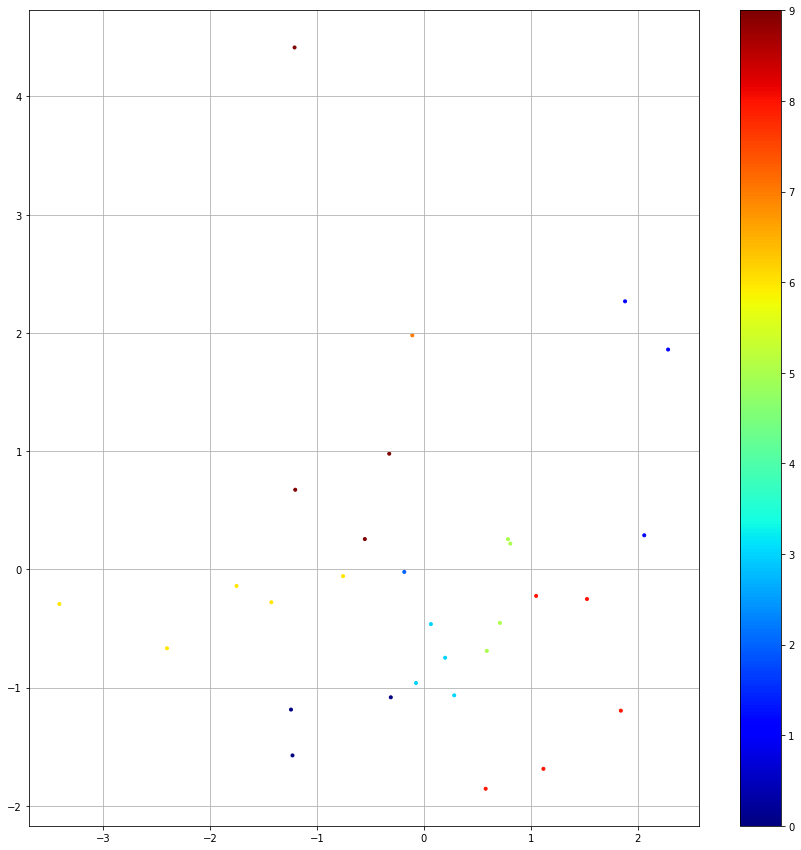

In [99]:
#次元数が2の時のプロット
if latent_dim == 2:
  plt.figure(figsize=(15, 15))
  plt.scatter(z[:, 0], z[:, 1], marker='.', c=num, cmap=pylab.cm.jet)
  plt.colorbar()
  plt.grid()
  plt.savefig("./fig.png")

In [100]:
#元画像と再構成後の画像を保存するなら
if save_img:
  value = int(math.sqrt(batch_size))
  pic = to_img(img.cpu().data)
  pic = torchvision.utils.make_grid(pic,nrow = value)
  save_image(pic, './dc_img/real_image_{}.png'.format(epoch))  #元画像の保存
        
  pic = to_img(output.cpu().data)
  pic = torchvision.utils.make_grid(pic,nrow = value)
  save_image(pic, './dc_img/image_{}.png'.format(epoch))  #再構成後の画像の保存

In [ ]:
#もし学習時ならモデルを保存
#バージョン管理は各々で
if train == True:
  torch.save(model.state_dict(), './conv_Variational_autoencoder_{}dim.pth'.format(latent_dim))

### <font color=red>F. </font>Keras で VAE 入門
https://fisproject.jp/2018/09/vae-with-python-keras/

<font size=5><font color=red>2018.09.15時点のコード。</font>C.と同じ？</font>

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from keras.utils import np_utils

# load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

# convert class vectors to 1-of-K format
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.01, wspace=0.01)
for i in range(100):
  ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
  ax.imshow(X_train[i].reshape((28, 28)), cmap='gray')

In [ ]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

K.clear_session()

img_shape = (28, 28, 1)
epochs = 10
batch_size = 256
latent_dim = 2  # Dimensionality of the latent space: a plane

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same',
                  activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same',
                  activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same',
                  activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same',
                  activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [ ]:
def sampling(args):
  z_mean, z_log_var = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                            mean=0.,
                            stddev=1.)
  return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# This is the input where we will feed `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsample to the correct number of units
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Reshape into an image of the same shape as before our last `Flatten` layer
x = layers.Reshape(shape_before_flattening[1:])(x)

# We then apply then reverse operation to the initial
# stack of convolution layers: a `Conv2DTranspose` layers
# with corresponding parameters.
x = layers.Conv2DTranspose(32, 3,
                           padding='same',
                           activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same',
                  activation='sigmoid')(x)
# We end up with a feature map of the same size as the original input.

# This is our decoder model.
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

In [ ]:
class CustomVariationalLayer(keras.layers.Layer):
  def vae_loss(self, x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
    kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

  def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x, z_decoded)
    self.add_loss(loss, inputs=inputs)
    # We don't use this output.
    return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_img, z_decoded])

In [ ]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

In [ ]:
history = vae.fit(x=x_train, y=None,
                  shuffle=True,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_data=(x_test, None))

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(1,epochs), loss[1:], marker='.', label='loss')
plt.plot(range(1,epochs), val_loss[1:], marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample = np.array([[xi, yi]])
    z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
    x_decoded = decoder.predict(z_sample, batch_size=batch_size)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size,
           j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

### <font color=red>G. </font>VAEをkerasで実装
https://qiita.com/iss-f/items/c43b23815fc6d15ae22e

<font color=red size=5>2018.02.12時点のコード。後回し</font>

### <font color=red>H. </font>書籍「deep learning with python」が公開しているVAEのサンプルコード
https://github.com/fchollet/deep-learning-with-python-notebooks

<font size=5 color=red>投稿日：2017.09.10\
**kerasの最新ver.では実行エラー**</font>

In [11]:
!pip install keras==2.4.3

  Found existing installation: Keras 2.4.0
    Uninstalling Keras-2.4.0:
      Successfully uninstalled Keras-2.4.0


In [1]:
!pip install keras==2.0.8

In [12]:
!pip show keras

Name: Keras
Version: 2.4.3
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: h5py, scipy, pyyaml, numpy
Required-by: textgenrnn, keras-vis, kapre, fancyimpute


In [13]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

# kerasのバージョンダウンにあわせて、tensorflowもバージョンダウンが必要。。

In [14]:
keras.__version__

#'2.0.8' in sample code

'2.4.3'

In [27]:
# 初期化/リセット
K.clear_session()

In [ ]:
'''

# Encode the input into a mean and variance parameter
z_mean, z_log_variance = encoder(input_img)

# Draw a latent point using a small random epsilon
z = z_mean + exp(z_log_variance) * epsilon

# Then decode z back to an image
reconstructed_img = decoder(z)

# Instantiate a model
model = Model(input_img, reconstructed_img)

# Then train the model using 2 losses:
# a reconstruction loss and a regularization loss

'''

In [29]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  # Dimensionality of the latent space: a plane

In [30]:
input_img = keras.Input(shape=img_shape)

In [31]:
x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)

x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)

x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)

x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)

x = layers.Dense(32, activation='relu')(x)

In [32]:
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [33]:
def sampling(args):
  z_mean, z_log_var = args
  epsilon = K.random_normal(
      shape=(K.shape(z_mean)[0], latent_dim),
      mean=0.,
      stddev=1.
      )
  return z_mean + K.exp(z_log_var) * epsilon

In [34]:
z = layers.Lambda(sampling)([z_mean, z_log_var])

In [35]:
# This is the input where we will feed `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])

In [36]:
# Upsample to the correct number of units
x = layers.Dense(
    np.prod(shape_before_flattening[1:]),
    activation='relu'
    )(decoder_input)

In [37]:
# Reshape into an image of the same shape as before our last `Flatten` layer
x = layers.Reshape(shape_before_flattening[1:])(x)

In [38]:
# We then apply then reverse operation to the initial
# stack of convolution layers: a `Conv2DTranspose` layers
# with corresponding parameters.
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)

x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)
# We end up with a feature map of the same size as the original input.

In [39]:
# This is our decoder model.
decoder = Model(decoder_input, x)

In [40]:
# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

In [41]:
class CustomVariationalLayer(keras.layers.Layer):

  def vae_loss(self, x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
    kl_loss = -5e-4 * K.mean(
        1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

  def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x, z_decoded)
    self.add_loss(loss, inputs=inputs)
    # We don't use this output.
    return x

In [42]:
# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_img, z_decoded])

In [43]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
_______________________________________________________________________________________

In [44]:
# Train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

In [45]:
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

In [55]:
keras.__version__

'2.4.3'

In [54]:
vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

Epoch 1/10


_SymbolicException: ignored

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import norm

In [ ]:
# Display a 2D manifold of the digits

n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

In [ ]:
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

In [ ]:
for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample = np.array([[xi, yi]])
    z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
    x_decoded = decoder.predict(z_sample, batch_size=batch_size)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size,
           j * digit_size: (j + 1) * digit_size] = digit

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()